# Roget's Thesaurus in the 21st Century

The first known thesaurus was written in the 1st century CE by [Philo of Byblos](https://en.wikipedia.org/wiki/Philo_of_Byblos); it was called *Περὶ τῶν διαφόρως σημαινομένων*, loosly translated in English as *On Synonyms*. Fast forward about two millenia and we arrive to the most well known thesaurus, compiled by [Peter Mark Roget](https://en.wikipedia.org/wiki/Peter_Mark_Roget), a British physician, natural theologian, and lexicographer. [Roget's Thesaurus](https://en.wikipedia.org/wiki/Roget%27s_Thesaurus) was released on 29 April 1852, containing 15,000 words. Subsequent editions were larger, with the latest totalling 443,000 words. In Greek the most well known thesaurus, *Αντιλεξικόν ή Ονομαστικόν της Νεοελληνικής Γλώσσης* was released in 1949 by [Θεολόγος Βοσταντζόγλου](https://el.wikipedia.org/wiki/%CE%98%CE%B5%CE%BF%CE%BB%CF%8C%CE%B3%CE%BF%CF%82_%CE%92%CE%BF%CF%83%CF%84%CE%B1%CE%BD%CF%84%CE%B6%CF%8C%CE%B3%CE%BB%CE%BF%CF%85); the latest updated edition was released in 2008 and remains an indispensable source for writing in Greek.

Roget organised the entries of the thesaurus in a hierarchy of categories. Your task in this assignment is to investigate how these categories fare with the meaning of English words as captured by Machine Learning techniques, namely, their embeddings.

Note that this is an assignment that requires initiative and creativity from your part. There is no simple right or wrong answer. It is up to you to find the best solution. You have three weeks to do it. Make them count.


<hr>

## Konstantinos Eleftheriou, p3200283

<b>NOTE:</b> Because the data where too big to be uploaded in MS Teams, you can download the word embeddings, and models for both Fasttext and GloVe from the link below, make sure to add them in the same path as the notebook.
https://drive.google.com/drive/folders/1J0WV5Xd528_cCVnz1BApbACw6wgn2pwR?usp=sharing

In [1]:
from bs4 import BeautifulSoup
import requests
import csv
import re
import os

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

## Get Roget's Thesaurus Classification

You can find [Roget's Thesaurus classification online at the Wikipedia](https://en.wiktionary.org/wiki/Appendix:Roget%27s_thesaurus_classification). You must download the categorisation (and the words belonging in each category), save them and store them in the way that you deem most convenient for processing.

<hr>

Let's start, by grabbing our data from the [The Project Gutenberg eBook of Roget's Thesaurus](https://www.gutenberg.org/cache/epub/22/pg22-images.html). For that, we can send a GET request, to receive the HTML content and use `BeautifulSoup` to crawl the data we need.

In [2]:
try:
    r = requests.get("https://www.gutenberg.org/cache/epub/22/pg22-images.html")
except requests.exceptions.ConnectionError as ce:
    print(ce)
else:
    print("Page retrieval OK")

soup = BeautifulSoup(r.text, 'html.parser')
    
first_paragraph = soup.find('p')
    
if first_paragraph:
    print('\nFirst paragraph:')
    print(first_paragraph.get_text())
else:
    print("No paragraph found")

Page retrieval OK

First paragraph:
Title: Roget's Thesaurus


Our target now is, to find and capture all the classes, and for each one of the classes every sibling that is a `Section / Division`, and for each one of those, all the words that are grouped upon that section and class pair.

By taking a closer look at the HTML structure of the website at the area where we are interested, we observe that it follows a strict structure:

* Each new class is denoted by a `<div>` element with the class attribute set to chapter.
* Within this `<div>`, there is an `<h2>` tag containing the class name for that particular chapter.
* Following the `<h2>` tag, there are sibling `<h3>` tags representing the sections of the class, and in some cases, `<h2>` tags, that represent the divisions.
* Finally, each `<h3>` or `<h2>` tag, is followed by sibling `<p>` tags, which contain the words corresponding to that section and class.

Our task will be to iterate over all the `p` tags that are sibling of the `h3/h2` or `section/divisioν` tag, until we meet another `h3/h2` tag, meaning, a new section/divison.

In [3]:
from bs4 import BeautifulSoup

chapters = soup.find_all('div', {"class" : "chapter"})

for chapter in chapters:
    class_name = chapter.find('h2').text.strip()
    element = chapter.find_next(['h2', 'h3']).find_next_sibling()
    
    print('\n')
    print(class_name)

    # If next sibling of class is a division
    if element and element.name == 'h2':
        parent = element.find_parent()
        first_tag = parent.find()
        divisions = first_tag.find_next_siblings('h2')
        
        for division in divisions:
            heading = division.get_text().strip()
            print(heading)


    # In next sibling of class is a section
    elif element and element.name == 'h3':
        parent = element.find_parent()
        sections = parent.find_all('h3')
        for section in sections:
            heading_section = section.get_text().strip()
            print((heading_section))



CLASS I
WORDS EXPRESSING ABSTRACT RELATIONS
SECTION I. EXISTENCE
SECTION II. RELATION
SECTION III. QUANTITY
SECTION IV. ORDER
SECTION V. NUMBER
SECTION VI. TIME
SECTION VII. CHANGE
SECTION VIII. CAUSATION


CLASS II
WORDS RELATING TO SPACE
SECTION I. SPACE IN GENERAL
SECTION II. DIMENSIONS
SECTION III. FORM
SECTION IV. MOTION


CLASS III
WORDS RELATING TO MATTER
SECTION I. MATTER IN GENERAL
SECTION II. INORGANIC MATTER
SECTION III. ORGANIC MATTER


CLASS IV
WORDS RELATING TO THE INTELLECTUAL FACULTIES
DIVISION (I) FORMATION OF IDEAS
DIVISION (II) COMMUNICATION OF IDEAS


CLASS V
WORDS RELATING TO THE VOLUNTARY POWERS
DIVISION (I) INDIVIDUAL VOLITION
DIVISION (II) INTERSOCIAL VOLITION[1]


CLASS VI
WORDS RELATING TO THE SENTIMENT AND MORAL POWERS
SECTION I. AFFECTIONS IN GENERAL
SECTION II. PERSONAL AFFECTIONS[1]
SECTION III. SYMPATHETIC AFFECTIONS
SECTION IV. MORAL  AFFECTIONS
SECTION V. RELIGIOUS AFFECTIONS


We have successfully found each class, with each nested sections/division.<br>
We notice however from the inital HTML Structure that, we still need to clean and perhaps remove some of the words that we should capture, inside each section/division.

* More precisally, there are words that don't really add meaning to certain class/sections when they appear by themselves, such of those could be: `and`, `or`, `of` etc.
* Furthermore, it seems like our code seems to be also capturing single or two letter words,  which should also be eliminated for consistency and relevance.
* We should also take care of the formatting of the `class` and `section` names, as well as cleaning individual word or sentences before we save them in any storage file.

Firstly, we will go ahead and download a list of common stopwords provided by `NLTK (Natural Language Toolkit)` in order to address the issue we were facing with common words that seem to not contribute significantly.<br>
We will also provide some extra `stop_words` that seem to appear too often, and clearly, do not make much sense when they appear alone.

In [4]:
!pip install nltk
print('\n')

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
custom_stop_words = {'adj', 'adv', 'obs3', 'nan'}
stop_words.update(custom_stop_words)

print(stop_words)


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


{'against', 'am', 'her', 'were', 'we', 'needn', 'then', 'them', 'mightn', 'what', 'when', 'such', 'do', 'd', 'aren', "doesn't", 'most', 'there', 'below', 'couldn', 'same', 'yours', 'no', 'other', 'haven', 'not', "hasn't", 'him', 'through', 'and', 'a', 'i', 'as', 'an', 'after', 'once', 'have', 'if', 'on', 'y', "isn't", 'but', 'yourself', 't', 'more', 'are', 'out', 'in', 'they', 'whom', 'up', 'into', 'before', 're', "mustn't", 'all', 'these', 'weren', 'ours', "you'd", "mightn't", 'off', 'wouldn', 'so', 'was', 'very', 'our', 'above', 'any', 'or', 'own', 'who', 'm', 'each', 'how', 'by', 'than', 'shan', 'obs3', 'is', 'until', 'at', 'because', 'himself', 'he', "you're", 'now', "wouldn't", 'theirs', 'where', 'their', 'over', 'few', 'that', 'further', "shan't", 'both', "won't", 'adv', 'wasn', 'ma', 'has', "it's", "aren't", 've', "didn't", 'adj', 'ain', 'nan', 'its', 'why', 'should',

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kwstasel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We will then introduce the `clean_headers` method, responsible for formatting the `class` and `section / divisions` parts, as we mentioned earlier.
This method receives a heading, and is responsible for removing all `SECTION/DIVISIONS` or `CLASS` tags, as well as any symbols.

In [5]:
def clean_headers(heading):
    
    # Removing of SECTION/CLASS/DIVISION labels with their Roman numerals or letters, 
    # standalone Roman numerals, and numbers in brackets
    cleaned_heading = re.sub(
        r'(SECTION|CLASS|DIVISION)\s*(\([IVXLCDM]+\)|[IVXLCDM]+)?\.?\s*'
        r'|^\[?\d+\]?'
        r'|^[ivxlcdm]+\.\s*'
        r'|^[ivxlcdm]+\s'
        r'|\[\d+\]', 
        '', heading, flags=re.IGNORECASE)
    
    # Replacing newline characters with a space and remove leading/trailing spaces
    cleaned_heading = re.sub(r'[\r\n]+', ' ', cleaned_heading).strip().lower()
    
    return cleaned_heading

Lastly, we will create a method, that will beresponsible for ensuring that only relevant and informative content is captured.<br>

More precisally, this method will combine several techniques, and will apply those in the inputted word/sentences and will decide whether this word or sentence is actually meaningful.

We will be using:
* <b>Stop Words</b>: to removed, as they offer little to no value in understanding the text's overall meaning.<br>
* <b>A Word / Sentence length filter</b>: To avoid including words that don't meet a certain threshold.
This thresholding basically acts as a secondary filter, capturing and excluding elements with insufficient content value—those that slip through the stop words filter.
* <b>Frequency Filter</b>: Mainly to balance between excluding overly common ones, which may not add much unique insight.
* <b>Duplication Check</b>: Ensuring the uniqueness each word in a certain section/division.

In [6]:
from collections import Counter

word_frequencies = Counter()

# Calculating the word frequencies across all the chapters.
def calculate_word_frequencies(chapters):
    for chapter in chapters:
        section_elements = chapter.find_all("h3")
        for section_element in section_elements:
            next_sibling = section_element.find_next_sibling()
            while next_sibling and next_sibling.name != 'h3':
                text = next_sibling.get_text(separator=' ', strip=True).lower()
                words = re.findall(r'\b(?:\w+(?:\s+\w+)*)', text)
                word_frequencies.update(words)
                next_sibling = next_sibling.find_next_sibling()

# Function that decides if a given sentence is informative
# based on the below criterias.
def is_informative(sentence, duplicates):
    common_threshold = 100    
        
    return (sentence not in stop_words and
            len(sentence) > 3 and
            word_frequencies.get(sentence, 0) < common_threshold and
            sentence not in duplicates)

Finally, we will also implement a function that will clean the words/sentences.

In [7]:
def clean_sentence(sentence):
    
    # Removing numbers along with any following alphabetic characters
    sentence_no_numbers = re.sub(r"\b[0-9]+[a-zA-Z]*", ' ', sentence)
    sentence_cleaned = re.sub(r"[^a-zA-Z\s]", '', sentence_no_numbers)
    
    # Contatenating text that seemed to be displayed in 2 lines.
    sentence_cleaned = ' '.join(sentence_cleaned.splitlines())

    return sentence_cleaned


And lastly, we will encapsulate the whole process of retrieving the words and saving them into a csv format.

In [8]:
classes = {}


# Crawls and receives the thesaurus data in the hierarchical order
# that it follows.
def get_thesaurus_words(download=False, print_limit=25):
    
    data = []
    index = 0
    
    # Receives all the words within a certain section/division.
    def get_words(element, stop_tag):
        words = set()
        while element and element.name != stop_tag:
            text = element.get_text(separator=' ', strip=True).lower()
            # Regex: Looks for sequences of words that might be 
            # separated by spaces and can include words with apostrophes.
            for word in re.findall(r"\b(?:\w+'?\w*)+(?:\s+\w+'?\w*)*", text):
                cleaned_word = clean_sentence(word)
                if is_informative(cleaned_word, words):
                    words.add(cleaned_word)
            element = element.find_next_sibling()
        return words
    
    # Finds all chapters / classes
    chapters = soup.find_all("div", {"class": "chapter"})    
    calculate_word_frequencies(chapters)
    
    # Iterating over all the classes.
    for chapter in chapters:
        class_name = clean_headers(chapter.find('h2').get_text().strip())
        classes[class_name] = index # Saving the classes to a dictionary for later.
        index += 1
                
        element = chapter.find_next(['h2', 'h3']).find_next_sibling()
        
        # Handling divisions (h2) elements specifically.
        if element and element.name == 'h2':
            first_tag = chapter.find()
            divisions = first_tag.find_next_siblings('h2')
            for division in divisions:
                heading = division.get_text().strip()
                division_header_cleaned = clean_headers(heading)
                next_division_sibling = division.find_next_sibling()
                words = get_words(next_division_sibling, 'h2')
                for word in words:
                    data.append([class_name, division_header_cleaned, word])
                    
        # Handling section ('h3)' elements specifically.
        elif element and element.name == 'h3':
            sections = chapter.find_all('h3')
            for section in sections:
                heading_section = section.get_text().strip()
                section_header_cleaned = clean_headers(heading_section)
                next_sibling = section.find_next_sibling()

                words = get_words(next_sibling, 'h3')
                for word in words:
                    data.append([class_name, section_header_cleaned, word])
    
    if download:
        with open('words.csv', 'w', newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['class', 'section', 'word'])
            csv_writer.writerows(data)
    else:
        random.shuffle(data)
        for row in data[:print_limit]:
            print(row)

get_thesaurus_words()


['words relating to the sentiment and moral powers', 'moral  affections', 'improbity']
['words relating to space', 'motion', 'moveless']
['words relating to the voluntary powers', 'intersocial volition', 'play first fiddle']
['words relating to the sentiment and moral powers', 'moral  affections', 'rough']
['words relating to the voluntary powers', 'individual volition', 'promptitude']
['words relating to the voluntary powers', 'intersocial volition', 'take prisoner']
['words relating to the voluntary powers', 'individual volition', 'apace']
['words relating to the intellectual faculties', 'communication of ideas', 'the new york times news service']
['words relating to the intellectual faculties', 'communication of ideas', 'stick in ones throat']
['words relating to matter', 'organic matter', 'oogamy']
['words relating to matter', 'organic matter', 'hider']
['words relating to the voluntary powers', 'individual volition', 'bad is the best']
['words relating to the voluntary powers', 'i

In [9]:
words_file = './words.csv'

if not os.path.exists(words_file):
    get_thesaurus_words(download=True)

## Get Word Embeddings

You will embeddings for the word entries in Roget's Thesaurus. It is up to you to find the embeddings; you can use any of the available models. Older models like word2vec, GloVe, BERT, etc., may be easier to use, but recent models like Llama 2 and Mistral have been trained on larger corpora. OpenAI and Google offer their embeddings through APIs, but they are not free.

You should think about how to store the embeddings you retrieve. You may use plain files (e.g., JSON, CSV) and vanilla Python, or a vector database.

<hr>
Now that we have our data ready, we can go ahead and read the csv.<br>
Our dataset has approximatelly 70k words, categorizing each one of them into it's class along with the section/division.

In [10]:
thesaurus_data = pd.read_csv(words_file)
thesaurus_data = thesaurus_data.dropna(subset=['word'])


print(thesaurus_data.shape)
thesaurus_data.sample(5)

(69402, 3)


class  \
61477  words relating to the sentiment and moral powers   
62282  words relating to the sentiment and moral powers   
21532                          words relating to matter   
52160            words relating to the voluntary powers   
16944                           words relating to space   

                      section             word  
61477     personal affections            prank  
62282  sympathetic affections           revere  
21532        inorganic matter    elastic fluid  
52160    intersocial volition      stockbroker  
16944                  motion  go out for walk

We can confirm that we safely captured the appropriate `sections / division`:

In [11]:
thesaurus_data['section'].unique()

array(['existence', 'relation', 'quantity', 'order', 'number', 'time',
       'change', 'causation', 'space in general', 'dimensions', 'form',
       'motion', 'matter in general', 'inorganic matter',
       'organic matter', 'formation of ideas', 'communication of ideas',
       'individual volition', 'intersocial volition',
       'affections in general', 'personal affections',
       'sympathetic affections', 'moral  affections',
       'religious affections'], dtype=object)

and also for the `classes`:

In [12]:
thesaurus_data['class'].unique()

array(['words expressing abstract relations', 'words relating to space',
       'words relating to matter',
       'words relating to the intellectual faculties',
       'words relating to the voluntary powers',
       'words relating to the sentiment and moral powers'], dtype=object)

With the data in our hands, we can now proceed to start thinking about which pre-trained word embedding model would do the best job for our purpose.

* Through out this assignment, we will be using and reporting our results on 2 word embedding models.
* The first one comes from `fasttext`. More specifically, this `fasttext` model is trained on Wikipedia articles and news 2017 data, with each word being displayed in 300 dimensions.
* The second one comes from `GloVe`. This `GloVe` model we will be picking, in comparison to `fasttext`, is trained on a combination of Wikipedia 2014 and `Gigaword 5` <br>
(Gigaword 5 consists of news articles collected from various sources, including newspapers, newswires, and online news sources). 
* Finally,`GloVe` embeddings are also available in 300 dimensions, which allows for a direct comparison when it comes to vector space dimensionality.
* The difference in training data sources and timeframes may result in different biases in the embeddings.<br><br>

Surely, there are a lot of models out there that are trained on bigger corpuses like `Llama 2`, however for simplicity reasons we will stick to a more naive way and thus opt for a more straight-forward solution.<br>
Nevertheless, it would be interesting to see how these simpler word embedding methods compare in various NLP tasks.


In [13]:
!pip install gensim
import gensim.downloader as api
import json

# Retrieves information on a pretrained word-embeddings model
fasttext_wiki_news_info = api.info('fasttext-wiki-news-subwords-300')
print(json.dumps(fasttext_wiki_news_info, indent=4))


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
{
    "num_records": 999999,
    "file_size": 1005007116,
    "base_dataset": "Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)",
    "reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/fasttext-wiki-news-subwords-300/__init__.py",
    "license": "https://creativecommons.org/licenses/by-sa/3.0/",
    "parameters": {
        "dimension": 300
    },
    "description": "1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).",
    "read_more": [
        "https://fasttext.cc/docs/en/english-vectors.html",
        "https://arxiv.org/abs/1712.09405",
        "https://arxiv.org/abs/1607.01759"
    ],
    "checksum": "de2bb3a20c46ce65c9c131e1ad9a77af",
    "file_name": "fasttext-wiki-news-subwords-300.gz",
    "parts": 1
}


In [14]:
# Retrieves information on a pretrained word-embeddings model
glove_wiki_gigaword_info = api.info('glove-wiki-gigaword-300')

print(json.dumps(glove_wiki_gigaword_info, indent=4))

{
    "num_records": 400000,
    "file_size": 394362229,
    "base_dataset": "Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)",
    "reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-wiki-gigaword-300/__init__.py",
    "license": "http://opendatacommons.org/licenses/pddl/",
    "parameters": {
        "dimension": 300
    },
    "description": "Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/).",
    "preprocessing": "Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-wiki-gigaword-300.txt`.",
    "read_more": [
        "https://nlp.stanford.edu/projects/glove/",
        "https://nlp.stanford.edu/pubs/glove.pdf"
    ],
    "checksum": "29e9329ac2241937d55b852e8284e89b",
    "file_name": "glove-wiki-gigaword-300.gz",
    "parts": 1
}


We go ahead and load them.

In [15]:
import os
from gensim.models import KeyedVectors

fasttext_file_path = './word_embeddings_fasttext.json'
glove_file_path = './word_embeddings_glove.json'

fasttext_model_path = './fasttext_model.bin'
glove_model_path = './glove_model.bin'

# Converting and saving the files in Gensim's native binary format
# as the loading times provided are significantly faster.
if not os.path.exists(fasttext_model_path) or not os.path.exists(glove_model_path): 
    print('Loading embedding models from API..')
    fasttext_model = api.load('fasttext-wiki-news-subwords-300')
    glove_model = api.load("glove-wiki-gigaword-300")
    

    fasttext_model.save_word2vec_format(fasttext_model_path, binary=True)
    
    # Save GloVe model to file
    glove_model.save_word2vec_format(glove_model_path, binary=True)
    
else:
    print('Loading stored embedding models..')
    fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=True)
    glove_model = KeyedVectors.load_word2vec_format(glove_model_path, binary=True)

Loading stored embedding models..


And also load the embeddings if available.

In [16]:
if os.path.exists(fasttext_file_path) and os.path.exists(glove_file_path):
    with open(glove_file_path, 'r') as f:
        word_embeddings_glove = json.load(f)
    with open(fasttext_file_path, 'r') as f:
        word_embeddings_fasttext = json.load(f)

We will implement a function, the will receive both model's and evaluate the word coverage for both of our pre-trained word embedding model's, that is `fasttext` and `GloVe`.

* For `fasttext`, approximately 47.50% of the words/sentences in the thesaurus are covered by the model's vocabulary.
* For `GloVe`, around 45.67% of the words in the thesaurus are covered.

<br>

However the results where expected, since `fasttext` rained on a bigger dataset (has captured around 1m words), whereas `GloVe` on a smaller one (has captured around 400k words).<br>

Additionally, as we mentioned `GloVe` is trained on combined dataset's. The quality of the data that `GloVe` model has been exposed, may also explain the performance and it's coverage percentage being close to fasttext.

In [17]:
rogets_thesaurus_vocab = set(thesaurus_data["word"])

def print_vocab_coverage(model):
    covered_words = 0

    for word in rogets_thesaurus_vocab:
        if word in model:
            covered_words += 1
            
    coverage_percentage = (covered_words / len(rogets_thesaurus_vocab)) * 100

    print("Vocabulary Coverage: {:.2f}%".format(coverage_percentage))
    
print('fasttext')
print_vocab_coverage(fasttext_model)
print()
print('GloVe')
print_vocab_coverage(glove_model)

fasttext
Vocabulary Coverage: 47.50%

GloVe
Vocabulary Coverage: 45.67%


We will also implement a simple function that will present for a random section of Roget's Thesaurus,<br> 
how close the words—or word embeddings—are in 2 dimensions just to get a better feeling on what we are working with.

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit_transform(fasttext_model.vectors)

# Visualizes relationships between pairs of words 
# from a randomly selected section.
def plot_pairs(pairs, projector, section, model):
    plt.figure(figsize=(7, 4))

    for words in pairs:
        embeddings = []
        for word in words:
            if word in model:
                embeddings.append(model.get_vector(word))
            else:
                print(f"Word '{word}' not present in the model's vocabulary.")
                embeddings.append([0] * model.vector_size)  # Using a zero vector for OOV words

        projected = projector.transform(embeddings)

        plt.scatter(projected[:, 0], projected[:, 1], color='b')
        plt.plot(projected[:, 0], projected[:, 1], color='b')
        for word, coords in zip(words, projected):
            plt.annotate(text=word, xy=coords + (0.005, 0.01))
            
    plt.title(f"Selected Section: {section}")
    plt.show()
    
def plot_section_pairs(projector, model, sample_size=10):
    random_section = random.choice(thesaurus_data['section'].unique())
    section_data = thesaurus_data[thesaurus_data['section'] == random_section]
    
    # Sample word pairs from the selected section
    random_pairs = section_data.sample(n=sample_size)[['word']].values.tolist()
    
    # Plot the word pairs
    plot_pairs(random_pairs, projector, random_section, model)

Word 'go to wrack and ruin' not present in the model's vocabulary.
Word 'sweep away' not present in the model's vocabulary.
Word 'tread under foot' not present in the model's vocabulary.
Word 'spike the guns' not present in the model's vocabulary.
Word 'interfere with' not present in the model's vocabulary.


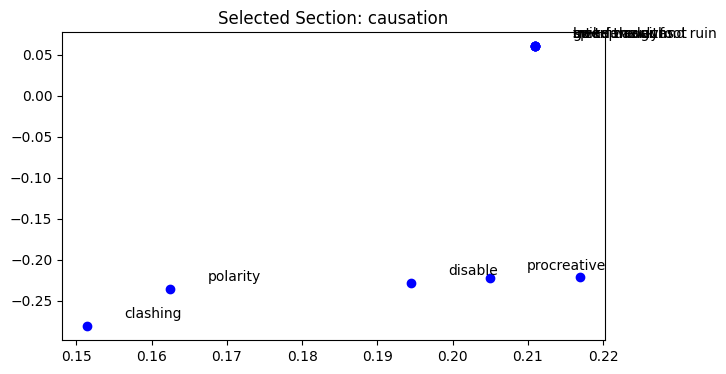

Word 'actual thing' not present in the model's vocabulary.
Word 'the reverse' not present in the model's vocabulary.
Word 'of a piece' not present in the model's vocabulary.
Word 'ridiculously like' not present in the model's vocabulary.
Word 'come amiss' not present in the model's vocabulary.


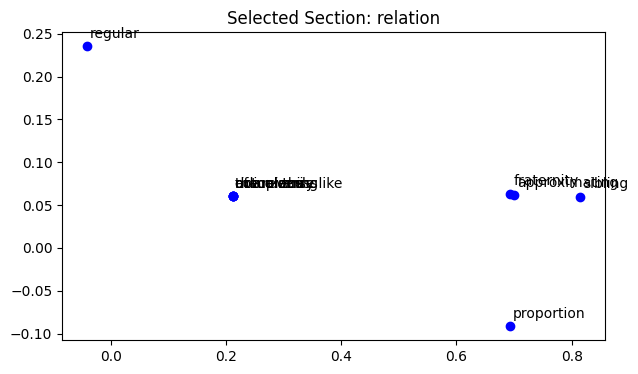

In [19]:
plot_section_pairs(pca, fasttext_model)
plot_section_pairs(pca, glove_model)

Let's begin by obtaining the pre-trained word embeddings for each term in our vocabulary.

Recognizing that some words or phrases may not be directly found in these models, especially those with multiple meanings or less common usage, we implement a strategy to address these gaps:

* Multi-Word Phrases: We split phrases into individual words, retrieve embeddings for each, and then average them to represent the phrase. This method will allow us to capture the semantic essence of phrases effectively.

* Handling Out-Of-Vocabulary (OOV) Words: For words not present in the model's vocabulary, instead of assigning them a zero-based or random vector, we will goahead and skip them for now, in order to avoid noise in our analysis.

* Normalization: We normalize the embeddings to standardize their length, ensuring uniformity and facilitating accurate semantic comparisons.

Finally, we store the word embeddings in JSON format, to allow us for reusability.

In [20]:
import numpy as np

def get_word_embeddings(vocab, model, vector_size=300):
    oov_vector = np.random.normal(size=vector_size)  # OOV vector
    
    def check(word):
        # Check if the word is a string and not NaN
        return isinstance(word, str) and word == word
    
    def get_embedding(word):
        try:
            return model.get_vector(word)
        except KeyError:
            if not check(word): return None  # Return None for unprocessable words
            
            if ' ' in word:  # Handling multi-word phrases
                words = word.split()
                word_embeddings = []
                for w in words:
                    try:
                        word_embeddings.append(model.get_vector(w))
                    except KeyError:
                        word_embeddings.append(oov_vector)
                return np.mean(word_embeddings, axis=0) if word_embeddings else None
            else:
                return None  # Return None if the word is not found
    
    def normalize_vector(vector):
        if vector is None:
            return None
        norm = np.linalg.norm(vector)
        if norm == 0:
            return vector
        return vector / norm

    embeddings = {}
    for word in vocab:
        embedding = get_embedding(word)
        if embedding is not None:  # Only add word if embedding was successfully retrieved
            embeddings[word] = normalize_vector(embedding).tolist()

    return embeddings



def save_embeddings(embeddings, filename):
    with open(filename, 'w') as f:
        json.dump(embeddings, f)

if not os.path.exists(fasttext_file_path) or not os.path.exists(glove_file_path):
    word_embeddings_glove = get_word_embeddings(rogets_thesaurus_vocab, glove_model)
    save_embeddings(word_embeddings_glove, 'word_embeddings_glove.json')
    
    word_embeddings_fasttext = get_word_embeddings(rogets_thesaurus_vocab, fasttext_model)
    save_embeddings(word_embeddings_fasttext, 'word_embeddings_fasttext.json')

We can confirm the we received the word embeddings:

In [21]:
def print_word_embeddings(word_embeddings, iterations=5):
    print("Word Embedding Dimension: ")
    for word, embedding in word_embeddings.items():
        print(f"Word: {word}, Embedding Shape: {len(embedding)}")
        iterations -= 1
        if iterations == 0:
            break
            
print_word_embeddings(word_embeddings_glove)

Word Embedding Dimension: 
Word: have no existence, Embedding Shape: 300
Word: xerox, Embedding Shape: 300
Word: throw the helve after the hatchet, Embedding Shape: 300
Word: put an extinguisher upon, Embedding Shape: 300
Word: without ballast, Embedding Shape: 300


And for `fasttext`:

In [22]:
print_word_embeddings(word_embeddings_fasttext)

Word Embedding Dimension: 
Word: have no existence, Embedding Shape: 300
Word: xerox, Embedding Shape: 300
Word: throw the helve after the hatchet, Embedding Shape: 300
Word: put an extinguisher upon, Embedding Shape: 300
Word: without ballast, Embedding Shape: 300


Finally, it would be interesting to see how close these embeddings are relative to their meaning between the two models.

We can do that, by computing the `cosine similarity`, that will measure the similarity between two vectors, or word embeddings, in innner product space.<br>

The similarity can receive values between -1 and 1:
* If the cosine similarity value is 1, it means the vectors are perfectly aligned, indicating maximum similarity.
* If the value is -1, it means the vectors are perfectly opposed, indicating maximum dissimilarity.
* If the value is 0, it means the vectors are orthogonal (perpendicular) to each other, indicating no similarity.

In [23]:
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

def print_word_embedding_similarity(word_embeddings1, word_embeddings2, iterations=5):
    print("Word Embedding Similarity: ")
    for word, embedding1 in word_embeddings1.items():
        if word in word_embeddings2:
            embedding2 = word_embeddings2[word]
            similarity = cosine_similarity(embedding1, embedding2)
            print(f"Word: {word}, Similarity: {similarity}")
            iterations -= 1
            if iterations == 0:
                break

print_word_embedding_similarity(word_embeddings_glove, word_embeddings_fasttext)

Word Embedding Similarity: 
Word: have no existence, Similarity: 0.025473106649787743
Word: xerox, Similarity: -0.04388553117175018
Word: throw the helve after the hatchet, Similarity: -0.00636275872199485
Word: put an extinguisher upon, Similarity: 0.022695206651211063
Word: without ballast, Similarity: 0.012902415981618105


## Clustering

With the embeddings at hand, you can check whether unsupervised Machine Learning methods can arrive at classifications that are comparable to the Roget's Thesaurus Classification. You can use any clustering method of your choice (experiment freely). You must decide how to measure the agreement between the clusters you find and the classes defined by Roget's Thesaurus and report your results accordingly. The comparison will be at the class level (six classes) and the section / division level (so there must be two different clusterings, unless you can find good results with hierarchical clustering).

<hr>

### Investigating Classes

Let's get back on our primary objective, which is evaluating the efficiency of machine learning models in identifying relationships between words, relative to those found in Roget's Thesaurus.

We'll start by exploring the capabilities of unsupervised learning in this context. Our approach involves feeding data into a model and then assessing its ability to find distinct patterns within the data.

In [24]:
print(len(thesaurus_data))
thesaurus_data.sample(10)

69402


class  \
40433            words relating to the voluntary powers   
16166                           words relating to space   
7443                words expressing abstract relations   
2150                words expressing abstract relations   
43075            words relating to the voluntary powers   
27755      words relating to the intellectual faculties   
40395            words relating to the voluntary powers   
55337  words relating to the sentiment and moral powers   
38314            words relating to the voluntary powers   
15614                           words relating to space   

                     section                   word  
40433    individual volition  beneath consideration  
16166                   form            blind alley  
7443                    time           postponement  
2150                quantity           incalculably  
43075    individual volition                not use  
27755     formation of ideas                   colt  
40395    individual volition                advised  
55337  affections in general    suspended animation  
38314    individual volition                prevail  
15614                   form             inflection

We will implement a method, that will receive the word embeddings of the vocabulary for a specific model, and generates a new dataframe.<br>
This new dataframe will consist of rows for each word and will have 1 column for the `word` iself, two for the `class/section` represented as numerical values, and finally, 300 additional columns each representing a dimension of the embedding.

However, in this step, we must take care for words that do not belong in the vocabulary. <br>
To handle this situation, we will first compute the mean embedding acrooss all collected embeddings and allocate the average of them to an OOV vector. This strategy was chosen to, again, avoid adding noise to our data.

In [25]:
def calculate_mean_embedding(model_embeddings):
    all_embeddings = np.array(list(model_embeddings.values()))
    mean_embedding = np.mean(all_embeddings, axis=0)
    return mean_embedding.tolist()

def transform_dataframe(original_df, model_embeddings):
    embedding_dim = 300
    original_df['class_num'] = original_df['class'].map(classes)
    original_df['section_num'], unique_sections = pd.factorize(thesaurus_data['section'])

    # Calculate mean embedding
    mean_embedding = calculate_mean_embedding(model_embeddings)
    
    new_rows = []

    for _, row in original_df.iterrows():
        word = row['word']
        class_num = row['class_num']
        section_num = row['section_num']
        
        # Usινγ the mean embedding as a placeholder for missing embeddings
        embedding = model_embeddings.get(word, mean_embedding)
        
        new_row = [word, class_num, section_num] + embedding
        new_rows.append(new_row)
    
    # Define column names for the new DataFrame
    columns = ['word', 'class_num', 'section_num'] + [f'dim_{i}' for i in range(1, embedding_dim + 1)]
    new_df = pd.DataFrame(new_rows, columns=columns)
    
    return new_df


We go ahead and transform the vocabulary to dataframes.

In [26]:
df_embedding_fasttext = transform_dataframe(thesaurus_data, word_embeddings_fasttext)
df_embedding_glove = transform_dataframe(thesaurus_data, word_embeddings_glove)

In [27]:
print(len(df_embedding_fasttext))
df_embedding_fasttext.head()

69402


word  class_num  section_num     dim_1     dim_2     dim_3  \
0  have no existence          0            0  0.034428 -0.015966  0.033048   
1   actual existence          0            0  0.044485 -0.048513  0.040462   
2            context          0            0  0.016906 -0.080905  0.001733   
3               live          0            0  0.007691  0.056361  0.056305   
4               true          0            0 -0.002475  0.000757  0.043225   

      dim_4     dim_5     dim_6     dim_7  ...   dim_291   dim_292   dim_293  \
0  0.024325 -0.008233 -0.034073  0.016853  ...  0.020155 -0.018584 -0.063903   
1  0.032423 -0.002135 -0.046267  0.017384  ...  0.033070  0.000960 -0.074448   
2  0.067747 -0.000740  0.001224  0.011316  ...  0.032411  0.029926  0.018587   
3  0.025422  0.059384 -0.029674  0.021144  ...  0.050517  0.036133 -0.066522   
4  0.017578 -0.077295 -0.027947  0.026226  ...  0.000140 -0.003956  0.025016   

    dim_294   dim_295   dim_296   dim_297   dim_298   dim_299   dim_300  
0 -0.037154  0.043903  0.011014 -0.009164 -0.045674 -0.050007  0.013308  
1 -0.038345 -0.001788  0.039304 -0.026106 -0.060285 -0.105762  0.036352  
2  0.071635  0.052470  0.031109  0.050045 -0.079688 -0.045879  0.028333  
3 -0.029168  0.005988  0.005062  0.040444 -0.005650 -0.060935  0.065441  
4  0.000066  0.030069  0.004426  0.030586  0.037016 -0.001102 -0.005765  

[5 rows x 303 columns]

Let's see if `KMeans` model can do a good job on this specific task.<br>
The goal of `KMeans` is to group data points into distinct non-overlapping subgroups. It does a very good job when the clusters have a kind of spherical shape.

Remember that our dataframe consists of `rows` that represent each one of the words that are going to be given to the algorithm, and `columns` corresponding to dimensions of the embeddings.<br>

We will go ahead and retrieve the embeddings from our dataframes.

In [28]:
starting_embedding_index = 3

embeddings_fasttext = df_embedding_fasttext.iloc[:, starting_embedding_index:]
embeddings_glove = df_embedding_glove.iloc[:, starting_embedding_index:]

print(len(embeddings_fasttext))
embeddings_fasttext.head()

69402


dim_1     dim_2     dim_3     dim_4     dim_5     dim_6     dim_7  \
0  0.034428 -0.015966  0.033048  0.024325 -0.008233 -0.034073  0.016853   
1  0.044485 -0.048513  0.040462  0.032423 -0.002135 -0.046267  0.017384   
2  0.016906 -0.080905  0.001733  0.067747 -0.000740  0.001224  0.011316   
3  0.007691  0.056361  0.056305  0.025422  0.059384 -0.029674  0.021144   
4 -0.002475  0.000757  0.043225  0.017578 -0.077295 -0.027947  0.026226   

      dim_8     dim_9    dim_10  ...   dim_291   dim_292   dim_293   dim_294  \
0 -0.157213  0.062044 -0.009766  ...  0.020155 -0.018584 -0.063903 -0.037154   
1 -0.158751  0.049439  0.004173  ...  0.033070  0.000960 -0.074448 -0.038345   
2 -0.122140 -0.024562 -0.077391  ...  0.032411  0.029926  0.018587  0.071635   
3 -0.125020  0.026395  0.003425  ...  0.050517  0.036133 -0.066522 -0.029168   
4 -0.140260  0.015838 -0.049697  ...  0.000140 -0.003956  0.025016  0.000066   

    dim_295   dim_296   dim_297   dim_298   dim_299   dim_300  
0  0.043903  0.011014 -0.009164 -0.045674 -0.050007  0.013308  
1 -0.001788  0.039304 -0.026106 -0.060285 -0.105762  0.036352  
2  0.052470  0.031109  0.050045 -0.079688 -0.045879  0.028333  
3  0.005988  0.005062  0.040444 -0.005650 -0.060935  0.065441  
4  0.030069  0.004426  0.030586  0.037016 -0.001102 -0.005765  

[5 rows x 300 columns]

In [29]:
embeddings_glove.head()

dim_1     dim_2     dim_3     dim_4     dim_5     dim_6     dim_7  \
0 -0.044724  0.055750 -0.036586  0.003980 -0.046330 -0.011942  0.007861   
1 -0.066271  0.092110 -0.003230 -0.002764 -0.080236 -0.000829 -0.008634   
2 -0.036408 -0.079387 -0.024879 -0.001409  0.079679  0.020093 -0.095393   
3 -0.055804  0.073685 -0.047786  0.056953 -0.042139  0.095550 -0.023243   
4  0.010030  0.031500  0.063281 -0.023297  0.034188  0.025005  0.000427   

      dim_8     dim_9    dim_10  ...   dim_291   dim_292   dim_293   dim_294  \
0 -0.007021  0.030804 -0.439776  ... -0.054269 -0.000402  0.037114  0.029503   
1  0.006940 -0.019211 -0.363566  ... -0.050981  0.015417  0.046193  0.007585   
2 -0.010199  0.032751 -0.362885  ...  0.042672  0.042178 -0.012547  0.014647   
3  0.000776  0.035638 -0.116348  ... -0.011963 -0.034912  0.029755 -0.018100   
4  0.057542 -0.037082 -0.279092  ... -0.001082 -0.000569  0.119447  0.012547   

    dim_295   dim_296   dim_297   dim_298   dim_299   dim_300  
0  0.002995  0.031190 -0.005909 -0.102206 -0.002977  0.016093  
1 -0.001265  0.020155 -0.039623  0.064253  0.015240 -0.015380  
2  0.037874  0.013593 -0.012328  0.087884 -0.017110  0.019238  
3 -0.040539  0.011498 -0.003775  0.034805  0.003605 -0.011454  
4  0.027272 -0.069634  0.007718  0.033379  0.013727  0.069412  

[5 rows x 300 columns]

For best results, `KMeans` requires the data to be in dimensions that are smaller relative to the number of samples (curse of dimensionality), thus, we will skip PCA.<br> 

With our data prepared, it's clear that the task at hand (or for the model) involves distinguishing between six unique classes. <br> 

Before proceeding with this task, let's first employ the `Elbow Method` to determine a good value for k
based on the sum of squared distances (SSE) between data points and their respective cluster centroids. <br>
This option of course is optional but we think that providing it provides us with valuable in-sights.

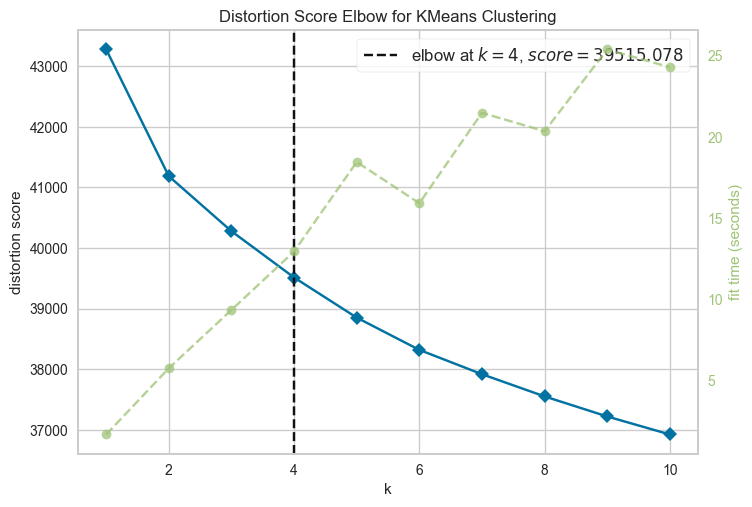

In [30]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(n_init=10)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(embeddings_fasttext)
_ = visualizer.show()

We go ahead and train the model in order to find the 6 classes.

In [31]:
from sklearn.metrics import silhouette_score

clusters = 6
kmeans = KMeans(n_clusters=clusters, n_init=10)
labels = kmeans.fit_predict(embeddings_fasttext)

silhouette_avg = silhouette_score(embeddings_fasttext, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.016921963557326062


Then, our next step is to visually inspect the clustering results.
To do this, we perform a dimensionality reduction using PCA, reducing the dataset to two dimensions, making it possible to visually see the separation of clusters.

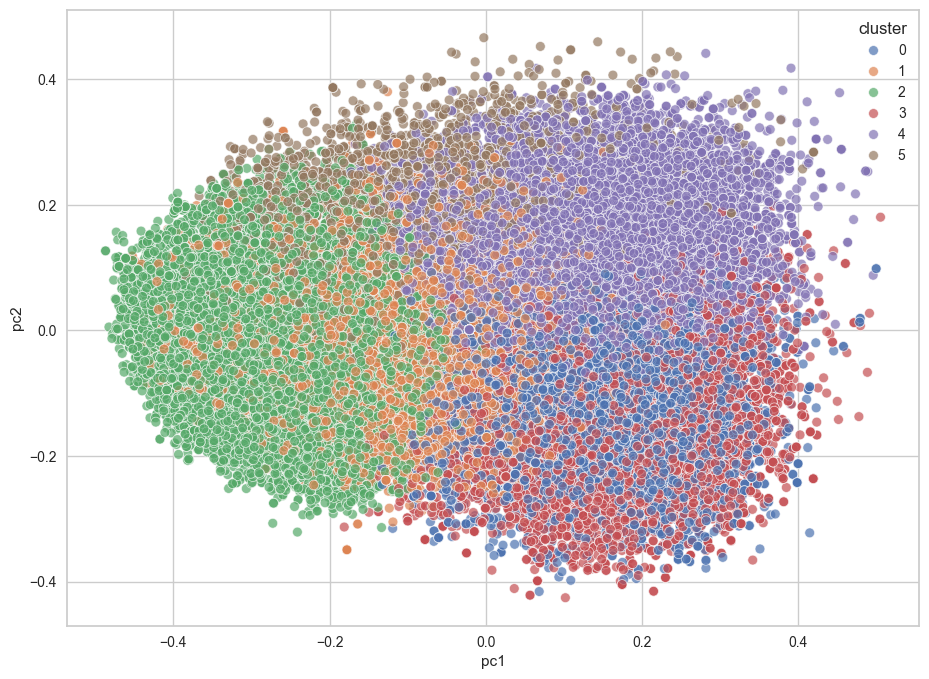

In [32]:
pca = PCA(n_components=2)
embeddings = pca.fit_transform(embeddings_fasttext)
df = pd.DataFrame(embeddings, columns=['pc1', 'pc2'])
df['cluster'] = labels

plt.figure(figsize=(11, 8))
_ = sns.scatterplot(data=df, x='pc1', y='pc2', hue='cluster', palette='deep', s=50, alpha=0.7)

Now we will extract the true class labels from our dataset and compare them with the labels predicted by the KMeans clustering algorithm.<br>
This could allows us to give us a first in-sight about the effectiveness of our unsupervised learning model in identifying the these hierarchical categories provided by the Thesaurus.

In [33]:
true_labels = df_embedding_fasttext['class_num']
predicted_labels = labels # where labels are the predicted one's returned by KMeans

print(true_labels)
print(predicted_labels)

print(len(true_labels) == len(predicted_labels))

0        0
1        0
2        0
3        0
4        0
        ..
69397    5
69398    5
69399    5
69400    5
69401    5
Name: class_num, Length: 69402, dtype: int64
[1 0 0 ... 0 4 3]
True


We proceed this rigorous evaluation of our clustering results by using the `Adjusted Rand Index` (ARI).

The `ARI` measures the similarity between two data clusterings, with a score close to 1 indicating total agreement and scores close to 0 or negative values indicating random or independent assignments, respectively.<br>

Our ARI score is about 0.011. This means that while our model demonstrates a basic ability to identify some relationships among the words, it does not grasp fully the connections or groups that characterizes the Thesaurus.

In [34]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(true_labels, predicted_labels)

print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.011820195799072272


Recall that during our initial clustering procedure, we utilized word embeddings from the `fasttext` model.<br>
We will now explore the impact of using `GloVe` model embeddings, which we have previously imported, to see if the clustering results differ in any way.<br>

We will go ahead and encapsulate the entire clustering procedure within a function, for reusability purposes.<br>
We also further enchance this function by also computing the `Davies Bouldin` and `Calinski Harabasz` score for the clusters. These scoring methods serve as benchmarks to assess the quality of the clusters.<br>
More specifically:
* <b>Davies-Bouldin Score</b> computes how well the clustering has been done, by evaluativng the average similarity between clusters. It produces values from 0 to infinity, where 0 indicates the lowest similarity, and thus each cluster is well seperated, and higher values indicating greater similarities between clusters. Thus a lower value is desirable
* <b>Calinski Harabasz</b> measures how well clustering has been done by looking at how spread out the clusters are from each other and how tight the points are within each cluster. It gives higher scores for clusters that are well separated and compact, which is the desirable scenario.

In [35]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Method that runs, evaluates, and visualizes the clustering on the KMeans
def visualize_clusters(embeddings_x, n_init=10, visualize_elbow=False, 
                       silhouette=False, clusters=6, random_state=123):
    # KElbowVisualizer
    if visualize_elbow:
        kmeans = KMeans(n_init=n_init)
        visualizer = KElbowVisualizer(kmeans, k=(1, 11))
        visualizer.fit(embeddings_x)
        visualizer.show()
    
    # Silhouette Scores
    if silhouette:
        parameters = [2, 3, 4, 5, 6]
        kmeans_model = KMeans(n_init=n_init)
        silhouette_scores = []
        for n_clusters in parameters:
            kmeans_model.set_params(n_clusters=n_clusters)  
            kmeans_model.fit(embeddings_x)
            labels = kmeans_model.labels_
            silhouette_avg = silhouette_score(embeddings_x, labels)
            silhouette_scores.append(silhouette_avg)
            print('Number of Clusters:', n_clusters, 'Silhouette Score:', silhouette_avg)
        
        plt.bar(parameters, silhouette_scores, align='center', color='#722f59')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs Number of Clusters')
        plt.show()
    
    # Clustering
    kmeans = KMeans(n_clusters=clusters, n_init=n_init, random_state=random_state)
    labels = kmeans.fit_predict(embeddings_x)
    
    # Computing evaluation scores
    silhouette_avg = silhouette_score(embeddings_x, labels)
    db_index = davies_bouldin_score(embeddings_x, labels)
    ch_index = calinski_harabasz_score(embeddings_x, labels)

    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Score: {db_index}")
    print(f"Chalinski-Bouldin Score: {ch_index}")
    
    # PCA Visualization
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings_x)
    df = pd.DataFrame(embeddings_2d, columns=['pc1', 'pc2'])
    df['cluster'] = labels
    
    plt.figure(figsize=(11, 8))
    sns.scatterplot(data=df, x='pc1', y='pc2', hue='cluster', palette='deep', s=50, alpha=0.7)
    plt.show()
    
    return kmeans # Returning the model

The groups are closely together, indicating less distinction between clusters.<br>
The model found 3 large clusters, with other points from multiple groups overlap or fall into this clusters, suggesting a degree of inter-cluster similarity or less effective cluster separation.

This mix-up means that the clusters are some-what similar to each other and thus, that the model didn't do a great job at separating them clearly.

* The Silhouette Score is approximately at 0.016, suggesting that the clusters are not compact and well-separated in and there exists a considerable amount of overlaping.
* The Davies-Bouldin Score is at 4.2, which is relatively high, indicating that the clusters are not compact and lack good separation. 
* The Calinski-Harabasz Score is approximately 1800, indicating that the cluster separation is weak relative to the within-cluster compactness.

Silhouette Score: 0.01692158321093132
Davies-Bouldin Score: 4.204859233053527
Chalinski-Bouldin Score: 1794.582492747337


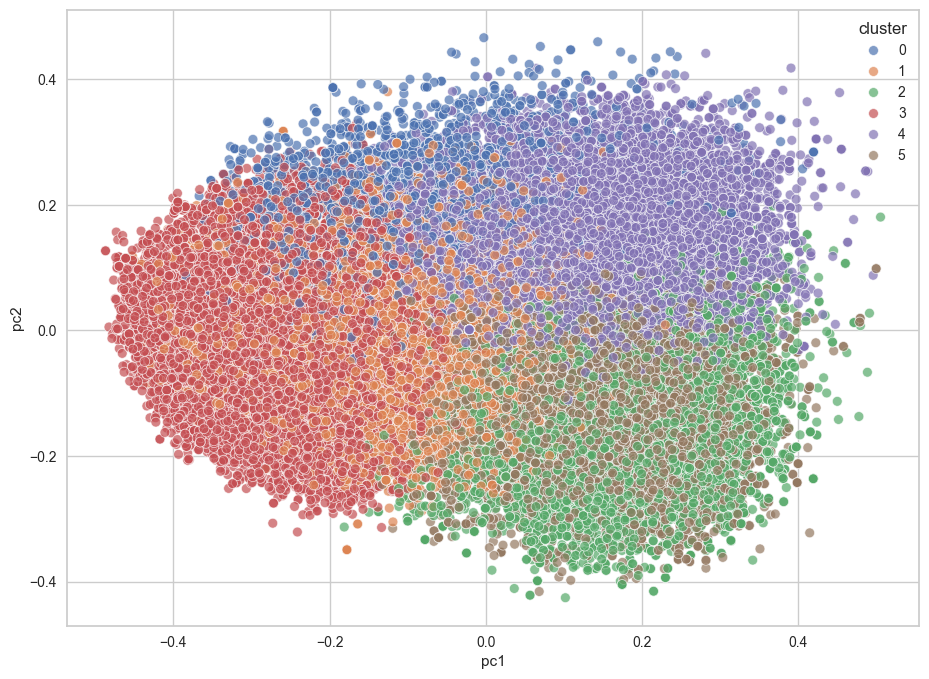

In [36]:
kmeans_fasttext_model = visualize_clusters(embeddings_fasttext)

The clustering we receive using the `GloVe` embeddings, represents a "brain" like picture, where each part of it appears to be a cluster.<br>
However, notice that there are still overlaps, while also one the groups seem to be on top of another.

* The Davies-Bouldin Score is higher, at 5.5, hinting that the clusters are not compact and distant.
* The Calinski-Harabasz Score is at 2576.32, which, while lower than FastText's score, still suggests that the separation between clusters is better than the cohesion within them, although not by an ideal margin.

Silhouette Score: 0.032795620431821104
Davies-Bouldin Score: 5.524472585982149
Chalinski-Bouldin Score: 2567.8386115894996


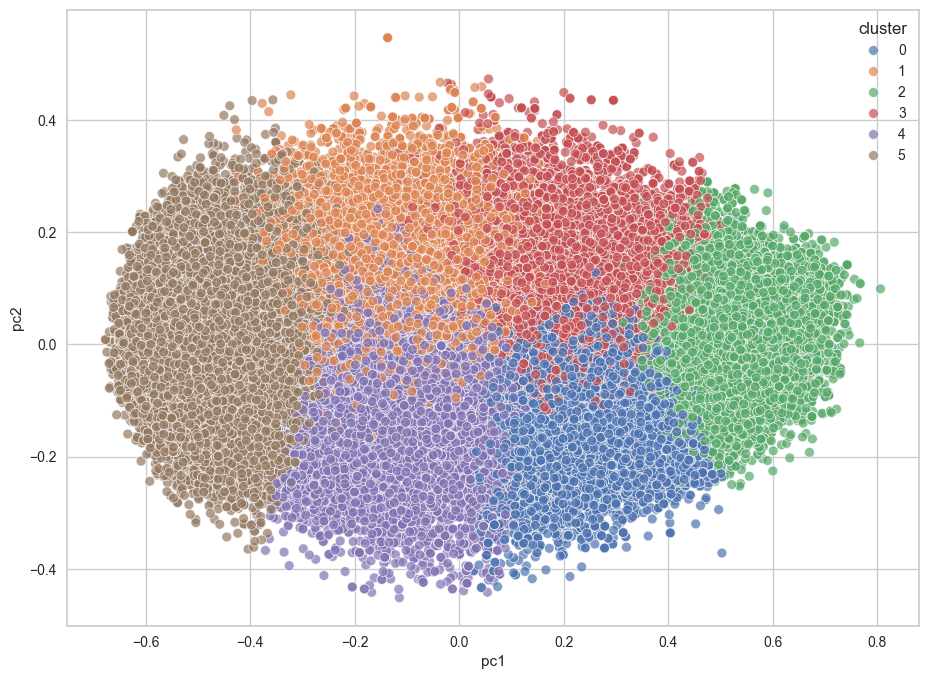

In [37]:
# Visualising clustering results from KMeans, using GloVe
kmeans_glove_model = visualize_clusters(embeddings_glove)

We can create a function to identify key words within each cluster, giving us insight into the main picture that is captured by those clusters. <br>
This process centers on examining the cluster centroids to determine the most characteristic words of each cluster.<br>
By closely examining these key words, we can start to form an idea about how each cluster might align with the categories found in Roget's Thesaurus. 

Essentially, this is what the `print_classification_report` function is in ended to measure as a numerical value.<br>
However, given that this method doesn't precisely measure how well our clustering matches the classifications in Roget's Thesaurus, we'll skip it for now.

In [38]:
from scipy.spatial import distance

def find_closest_words_to_centroids(df, original_embeddings, kmeans_model, keep_top_words=15):
    
    centroids = kmeans_model.cluster_centers_

    closest_words_indices = (
        distance.cdist(centroids, original_embeddings, 'euclidean')
        .argsort(axis=1)[:, :keep_top_words]
    )     
    
    for i, indices in enumerate(closest_words_indices):
        words = df.iloc[indices]['word'].tolist()
        print(f"\nCluster {i}: {words}")

        
from sklearn import metrics

def print_classification_report(remap_labels, model):
    
    remapped_labels = [ remap_labels[lbl] for lbl in model.labels_ ]
    targets = thesaurus_data['class_num']
    target_names = thesaurus_data['class'].unique()
    
    targets_aligned = targets[:len(remapped_labels)]


    print(metrics.classification_report(targets_aligned, remapped_labels, target_names=target_names))

We will go ahead and include into our thesaurus dataset, the cluster IDs obtained from the GloVe model's clustering.<br>

In [39]:
enhanched_thesaurus_data = thesaurus_data.copy()

enhanched_thesaurus_data['cluster_id_glove'] = kmeans_glove_model.labels_

From this, we generate a pivot table, mapping word classes to their respective clusters, providing a count of words per class in each cluster, meaning the table will show how many words from each class fall into each cluster.

This pivot table doesn't tell us exactly how well the model's groups match with the categories from Roget's Thesaurus, but it gives us a starting point to understand what kind of themes each cluster represents.

When we inspect the results, we see that each cluster contains words from various Roget's Thesaurus classes, not just one.<br> 
This mixture happens because many words have more than one meaning, which can make it challenging for the model to distinguish between different contexts and uses of the same word.

As a result, words from different thematic classes are often happen to be placed together in the same cluster. This shows us that our clustering model is some-what incapable of find the exact relationships of the words, as they are hierarchially ordered in Roget's Thesaurus.

In [40]:
pivot_table_glove = pd.pivot_table(enhanched_thesaurus_data, index='class', 
                                   columns='cluster_id_glove', 
                                   values='word', aggfunc='count', 
                                   fill_value=0)
pivot_table_glove

cluster_id_glove                                     0     1     2     3  \
class                                                                      
words expressing abstract relations               1438  1924  1680  1445   
words relating to matter                          1820   512  1393   490   
words relating to space                           2410   766  1657   520   
words relating to the intellectual faculties      1022  1750  1762  1430   
words relating to the sentiment and moral powers  1497  1441  2942  2419   
words relating to the voluntary powers            1859  2775  2441  1865   

cluster_id_glove                                     4     5  
class                                                         
words expressing abstract relations               1677  3288  
words relating to matter                          1602  1053  
words relating to space                           2014  1726  
words relating to the intellectual faculties      1707  3176  
words relating to the sentiment and moral powers  2533  3548  
words relating to the voluntary powers            2581  5239

We can confirm the above phenomenon if we print the most representative words from each cluster.

Notice that the words within each cluster come from a variety of themes or classes.

Again, this variety across clusters illustrates how the model groups words not strictly by their traditional categories but by their usage and context similarities, often blending meanings and themes within a single cluster.
For example, Cluster 1 seems to explain more "abstract concepts", while Cluster 5 seems to be capturing idiomatic expressions, and thus it's ability to caputre multi-words.

In [41]:
find_closest_words_to_centroids(df_embedding_glove, embeddings_glove, kmeans_glove_model)


Cluster 0: ['squeezers', 'impalpable', 'crupper', 'talebearer', 'osculate', 'inveigle', 'foreknow', 'pustule', 'tumid', 'doubtfulness', 'scaliness', 'dastard', 'interstice', 'extenuated', 'sourish']

Cluster 1: ['frizzly', 'unprovided', 'littleness', 'lenitive', 'irresolutely', 'unresistant', 'endue', 'muleteer', 'vincible', 'wooer', 'contrariety', 'besom', 'expertness', 'cosset', 'wonted']

Cluster 2: ['importune', 'ebullition', 'contumelious', 'calcine', 'burnisher', 'misconceive', 'overcritical', 'galvanism', 'compeer', 'uncleanly', 'manacle', 'prepossessed', 'frangibility', 'schoolfellow', 'bradawl']

Cluster 3: ['comfit', 'rollick', 'untaught', 'prepossession', 'changeableness', 'womanish', 'bloater', 'diffuseness', 'obtrude', 'inexpedience', 'indistinctness', 'misdo', 'abjectness', 'perambulator', 'transmogrify']

Cluster 4: ['trisect', 'timeserving', 'captious', 'cosset', 'limpidity', 'excursive', 'discompose', 'sonorousness', 'enrapture', 'confabulate', 'famish', 'carousal', '

We do the same procedure for `fasttext`:


Although the clustering results show a slightly clearer distribution, our model still encounters the challenge we previously discussed. 

That is, words from diverse Roget's Thesaurus classes are grouped together in the same clusters, indicating that, despite fasttext model trained on a vast vocabulary, it is still incapable in some way to find this relationship, just like we previously saw.

In [42]:
enhanched_thesaurus_data['cluster_id_fasttext'] = kmeans_fasttext_model.labels_

pivot_table_fasttext = pd.pivot_table(enhanched_thesaurus_data, index='class', 
                                      columns='cluster_id_fasttext', 
                                      values='word', aggfunc='count', 
                                      fill_value=0)
pivot_table_fasttext

cluster_id_fasttext                                 0     1     2     3     4  \
class                                                                           
words expressing abstract relations               342  2068  1669  2823  2018   
words relating to matter                          148   629   994   962  3088   
words relating to space                           181  1248   702  1655  4167   
words relating to the intellectual faculties      412  1881  1739  2723  1986   
words relating to the sentiment and moral powers  540  2264  3112  2985  2901   
words relating to the voluntary powers            665  2979  1921  4378  3939   

cluster_id_fasttext                                  5  
class                                                   
words expressing abstract relations               2532  
words relating to matter                          1049  
words relating to space                           1140  
words relating to the intellectual faculties      2106  
words relating to the sentiment and moral powers  2578  
words relating to the voluntary powers            2878

In [43]:
find_closest_words_to_centroids(df_embedding_fasttext, embeddings_fasttext, kmeans_fasttext_model)


Cluster 0: ['a short life and a merry one', 'have a half a mind to', 'be between a rock and a hard place', 'look for a needle in a haystack', 'between a rock and a hard place', 'give to airy nothing a local habitation and a name', 'a strong pull a long pull and a pull all together', 'a long pull a strong pull and a pull all together', 'a long pull a strong pull and a pull all together', 'like a horse in a mill', 'go round like a horse in a mill', 'a poem round and perfect as a star', 'a good turn', 'give a sprat to catch a herring', 'make a toil of a pleasure']

Cluster 1: ['jardiniere', 'bedizen', 'vicennial', 'lenitive', 'reecho', 'flabbergast', 'affiance', 'fitfulness', 'inexpedience', 'inopportunely', 'grandam', 'supervention', 'scutcheon', 'magniloquent', 'postmeridian']

Cluster 2: ['thirstiness', 'bowwow', 'bedaub', 'imperceptibility', 'vociferation', 'lambkin', 'jocosity', 'pantomimist', 'bypath', 'paltriness', 'backbiter', 'gormandize', 'gormandizing', 'asseverate', 'intrans'

### Investigating Sections

Let's now observe how unsupervised learning can work on finding sections.<br>
So we will, observe one layer deeper, on groups that display more focused areas.

We are looking for 24 sections/divisions.

In [44]:
print(len(thesaurus_data['section'].unique()))
unique_sections = thesaurus_data['section'].unique()

24


The scatterplot for fasttext look chaotic and doesn't seem to follow any patterns or distinct groups.

Silhouette Score: -0.0076056081742401525
Davies-Bouldin Score: 4.260011072708712
Chalinski-Bouldin Score: 718.7976984046558


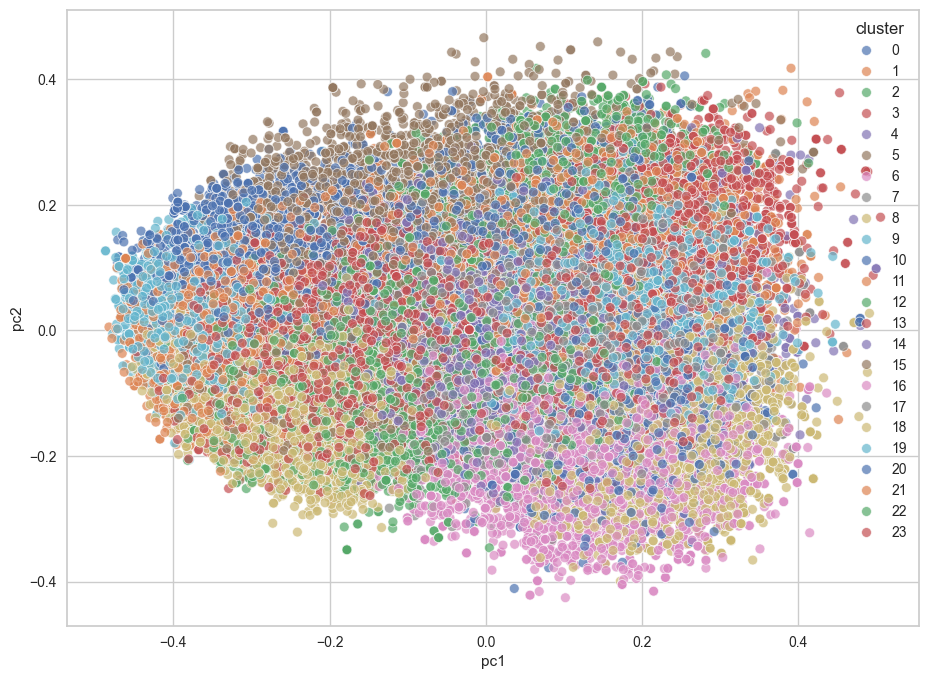

In [45]:
fasttext_section_model = visualize_clusters(embeddings_fasttext, clusters=24)

The picture when using GloVe, is a bit clearer showcasing a few separated groups.

Silhouette Score: -0.008152897308326568
Davies-Bouldin Score: 4.878771816587353
Chalinski-Bouldin Score: 782.2653047139806


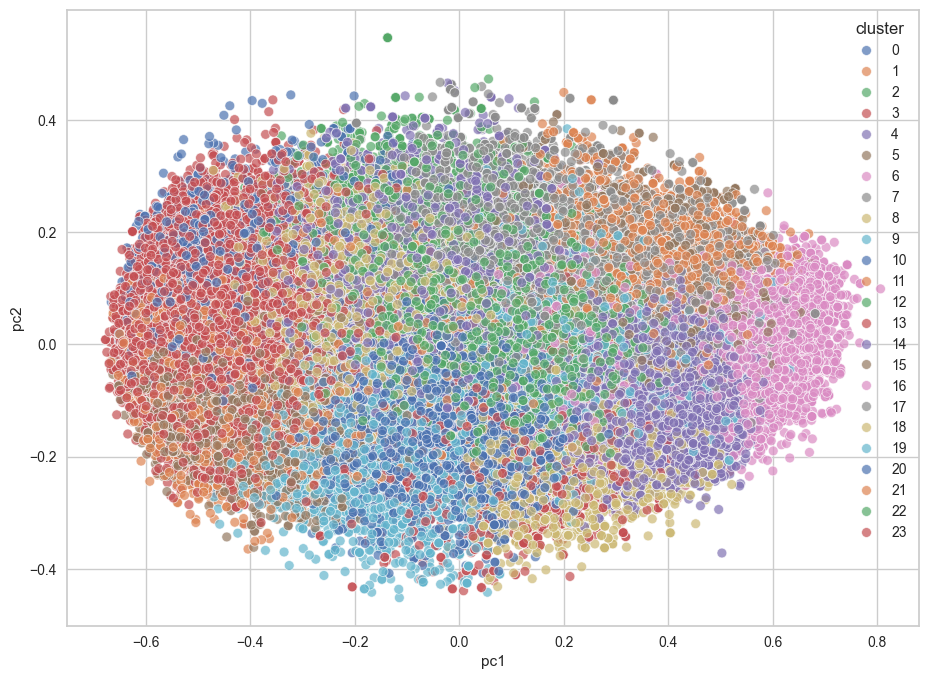

In [46]:
glove_section_model = visualize_clusters(embeddings_glove, clusters=24)

If we now go ahead and create a similar pivot table, but for the sections now.<br>
We notice that, even though each cluster seems to have a some-what unique section where it groups words by, there is 1 section in common, which is `Individual Volition` where every other cluster seems to share a significant number of words. <br>

This could suggest that words associated within the `Individual Volition` section are more common or maybe more ambiguously used within the dataset, which could explain them being more frequently assigned across different clusters. 

This instance, where the model clusters together words of different meanings, highlightes the previously discussed challenge of "polysemy".

In [47]:
enhanched_thesaurus_data = thesaurus_data.copy()

enhanched_thesaurus_data['section_id_fasttext'] = fasttext_section_model.labels_

pivot_table_fasttext = pd.pivot_table(enhanched_thesaurus_data, index='section', 
                                      columns='section_id_fasttext', 
                                      values='word', aggfunc='count', 
                                      fill_value=0)

pivot_table_fasttext

section_id_fasttext      0    1    2    3    4    5    6    7    8    9   ...  \
section                                                                   ...   
affections in general     4   32   49    7   20   46  119    9   43   21  ...   
causation                44   58   68   83   90   48  108   33   79   84  ...   
change                   18   15   57   27   36   28   32   19   42   21  ...   
communication of ideas  135  130  198  237   98  199  155  590  201  107  ...   
dimensions              277  141   33   50  262   44   67   55   75   39  ...   
existence                 7   16   43   27   23   14   39   13   14    5  ...   
form                    108   73   16   10  174   24   32   15   13    6  ...   
formation of ideas       49   56  501   92   81  210  308  178  297  196  ...   
individual volition     451  387  729  398  188  485  434  179  573  341  ...   
inorganic matter        130  348    7   33  151   15   54    9   42   10  ...   
intersocial volition    223   91  275  360   32  171  146   89  244  128  ...   
matter in general        17   31    5   19   42    6   14    2   16    0  ...   
moral  affections        54   94  184  128   13  150  211   64  190  111  ...   
motion                  367  169   98   64  198  106   46   60   80   75  ...   
number                   23    9   53   33  104   39   19   82   17    7  ...   
order                    76   24   74   79   99   57   55   96   68   39  ...   
organic matter          244  733  111  182  327  126  143  174  213   71  ...   
personal affections     111  202  397  115   49  241  375  187  292   96  ...   
quantity                 47   82  112   54  142   81   92   57   47   45  ...   
relation                  7    7   67   26   33   21   57   49   48   34  ...   
religious affections     65   24   43  129   18   10   87  108   90    5  ...   
space in general        325   41   26   64   49    6   11   13   24    6  ...   
sympathetic affections   33   58  183   71    3   88  166   50   92   50  ...   
time                     54   25  173   62   59   51   66   78  146   42  ...   

section_id_fasttext      14   15   16   17   18   19   20   21   22    23  
section                                                                    
affections in general    62   13   38   60  151    6   65   26    9   101  
causation               209   22  105   81  165   54  127   70   42   147  
change                   80   18   69   36   25    8   46   48    6    78  
communication of ideas  360   50  325  147  250  291  144  182  219   457  
dimensions              156   38  135  116   67   42   50  138  478   172  
existence                19   19   64   38   13    7   18   29    6    25  
form                     43    8   42   60   53   11   19   13  338    52  
formation of ideas      312   93  527  233  348  160  201  308   67   566  
individual volition     654  167  493  483  625  456  529  596  450  1018  
inorganic matter         57   12   52   20   78    7   24   15   86    48  
intersocial volition    404   64  190  145  155  457  186  240  201   400  
matter in general         4    3   19    6   17    8    3    2   24    13  
moral  affections       226   68  187  132  335  202  272  136   75   272  
motion                  216   20   53   67   73  116  120  170  247   262  
number                   48    5   91   56   21   29   15   27   40   101  
order                   125   14  138   62   68   23   68   80   37   152  
organic matter          144   51  180  125  250  144  197  107  272   367  
personal affections     282   89  245  197  765  191  360  228  175   496  
quantity                209   37  224  145   97   29   76   86  156   176  
relation                 51   13  131   58   34   28   41   51   16    83  
religious affections     67    5   33   30   81  151   81    7   43   133  
space in general         43   12   25   36   13   42   10   42   96    41  
sympathetic affections  118   38   86   87  313  157  166   99   27  

Again, while the model may not perfectly align with Roget's Thesaurus classifications, it has created some interesting groupings. <br>

For example, Cluster 15 interestingly groups together sentences that start with "be" and are followed by various words, revealing expressions related to primarily states or conditions, while Cluster 4 focuses on a mix of words that span from various themes and concepts, starting from relationships and emotions ('truelove', 'affiance', 'hymeneal') to actions or behaviors ('timeserving', 'waggery', 'thanklessness').

Notably, these clusters include duplicate words that, despite appearing identical, carry different meanings in various contexts. This also shows the inability of our model to understand words or phrases without any context.

In [48]:
find_closest_words_to_centroids(df_embedding_fasttext, embeddings_fasttext, fasttext_section_model)


Cluster 0: ['nonesuch', 'disembody', 'unsaddle', 'inexpiable', 'inexpedience', 'blear', 'demonetize', 'aigrette', 'affiance', 'compeer', 'supersaturate', 'misogamist', 'webfoot', 'inspirit', 'envenom']

Cluster 1: ['arbitrager', 'constipate', 'pitilessness', 'fitfulness', 'tenterhook', 'lingerer', 'windflower', 'muckrake', 'rarefy', 'lacteal', 'impressibility', 'regeneracy', 'arctics', 'supersaturate', 'lucubration']

Cluster 2: ['coquetting', 'overmaster', 'besot', 'pitapat', 'corrugate', 'upraise', 'peculator', 'disoblige', 'burnoose', 'hoyden', 'ministrant', 'lambkin', 'pauperize', 'quadruplication', 'temperateness']

Cluster 3: ['adumbration', 'obtrusion', 'nonesuch', 'furbelow', 'argosy', 'magniloquence', 'seignior', 'incarnadine', 'envenom', 'construable', 'unlimber', 'disarrange', 'plasticize', 'misogamist', 'smirch']

Cluster 4: ['rhymester', 'truelove', 'tenuity', 'timeserving', 'bowwow', 'waggery', 'middlemost', 'glaciate', 'thanklessness', 'dandle', 'affiance', 'hymeneal', 

In [49]:
enhanched_thesaurus_data['section_id_glove'] = glove_section_model.labels_

We observe similar results from the GloVe model.

In [50]:
pivot_table_glove = pd.pivot_table(enhanched_thesaurus_data, index='section', 
                                      columns='section_id_glove', 
                                      values='word', aggfunc='count', 
                                      fill_value=0)

pivot_table_glove

section_id_glove         0    1    2    3    4    5    6    7    8    9   ...  \
section                                                                   ...   
affections in general    50   77   17   53   67   63   56   71   20   59  ...   
causation               115   91  118   82   25  145  118   82   57   71  ...   
change                   51   37   51   59   12  109   52   28   35   16  ...   
communication of ideas  327  160  322  263  166  272  420  164  233  182  ...   
dimensions              264   54   86   61   21  234  296   41   65  150  ...   
existence                13   25   69   56   24   12   20   20   18    9  ...   
form                    123   22   27   17    6   76  153   28   18   82  ...   
formation of ideas      274  278  443  573  332  257  309  276  169  128  ...   
individual volition     793  395  357  862  296  937  706  413  490  358  ...   
inorganic matter         92   33   36    7    7   35  156   20   16  153  ...   
intersocial volition    294  140  134  292  108  400  322  106  436  113  ...   
matter in general        17   13   27    5    8    7   23   10    4   15  ...   
moral  affections       242  219   71  238  161  140  324  228  202   98  ...   
motion                  465   52   70  118   27  488  238   34   86  113  ...   
number                   82   26   59   57    7   67   51   18   47   18  ...   
order                   113   53  145   59   25  131   90   48   98   46  ...   
organic matter          320  102  208  161  121  190  452   86   85  415  ...   
personal affections     338  337  112  415  390  283  479  362  112  245  ...   
quantity                149  100  147  131   30  125  149   95   73   68  ...   
relation                 47   52   99   74   22   26   71   35   32   11  ...   
religious affections     65   86   30   27   95   15  129   37   48   19  ...   
space in general         70   14   30   25   18   52   73    8   56   55  ...   
sympathetic affections  149  146   38  178  195  121  168  161   75   73  ...   
time                    135   54   76  164   37  194  109   56   58   33  ...   

section_id_glove         14   15   16   17   18   19   20   21   22   23  
section                                                                   
affections in general    32   52   21   12   25   73   32   16   10    9  
causation                91  142   93   68   46   50  113   72   56   36  
change                   38   50   50   35   10    9   57   39   15   18  
communication of ideas  360  206  138  187  127  212  158   89  288   75  
dimensions              286  109  216   43  306   32   46   95   23  222  
existence                11   10   23   18    7   17   10   11   13    6  
form                    142   52  136   13  200   23   10   23    7  102  
formation of ideas      190  189  136  235   56  138  285   68  140   44  
individual volition     728  448  243  395  300  177  505  254  208  266  
inorganic matter        118   67  122   15  197   29   12   60   11  127  
intersocial volition    382  213   53  386   76   33  238  532  145   74  
matter in general        20    4   37    1    7    4    0   11    8    8  
moral  affections       216  150   28  287   71   75  150   71   68   35  
motion                  379  222  187   69  177   31  122  105   39  135  
number                   71   26  118   21   17    8   11   38   35   16  
order                    96   65  112   63   39   30   70   35   64   46  
organic matter          609  135  280   50  435  201   79  102  107  153  
personal affections     399  218   53   77  166  327  156   70  111   81  
quantity                 91  150  151   96  104   57   60  130   45   51  
relation                 32   24   75   39    9   29   38   21   25   13  
religious affections    187   38   16   31   20   30   14    4  218   20  
space in general        138   24   39   20   60   11    7   42   25  179  
sympathetic affections  175   88   12   54   46   97   76   28   58   31  
time              

In [51]:
find_closest_words_to_centroids(df_embedding_glove, embeddings_glove, glove_section_model)


Cluster 0: ['dogmatist', 'catcall', 'temperateness', 'nonattendance', 'enthrallment', 'talkativeness', 'inspirit', 'opalescence', 'hauberk', 'unhardened', 'pertinacity', 'becloud', 'nonplus', 'bedim', 'derange']

Cluster 1: ['dissimulate', 'betimes', 'throe', 'expurgate', 'anodize', 'barebacked', 'dissimilitude', 'refulgence', 'enameler', 'inclemency', 'bespangle', 'speechify', 'ungentle', 'electrotype', 'effervesce']

Cluster 2: ['caitiff', 'chirography', 'enrapture', 'salaams', 'superabundant', 'thanklessness', 'orotundity', 'confute', 'enameler', 'gnarl', 'speechify', 'catchpenny', 'magniloquent', 'effulgence', 'billhook']

Cluster 3: ['would you be so kind as to', 'not have a moment that one can call ones own', 'not be able to get out of ones head', 'better to be silent and thought a fool than to speak up and remove all doubt', 'have it all ones own way', 'have it all ones own way', 'no better than she should be', 'as good would have it', 'how happy could i be with either', 'stand

## Class Prediction

Now we flip over to supervised Machine Learning methods. You must experiment and come up with the best classification method, whose input will be a word and its target will be its class, or its section / devision (so there must be two different models).

<hr>

## Naive Bayes

Our problem is an instance of supervised learning. We have the training set with the assigned categories (where the category is the `class` or `section/division`.

Using pre-trained word embeddings with a Naive Bayes classifier introduces some complexities, as Naive Bayes is  used with count-based features (like Bag of Words or TF-IDF) rather than dense vector representations like word embeddings which we are dealing with <br>

However, we will go through this procedure as we believe it is a good choice for baseline model due to it's simplicity and efficiency.

Remember that we have for each word, it's assigned `class` and `section` in numeric values.

In [52]:
thesaurus_data.sample(15)

class  \
34297      words relating to the intellectual faculties   
13873                           words relating to space   
56956  words relating to the sentiment and moral powers   
1874                words expressing abstract relations   
59315  words relating to the sentiment and moral powers   
56967  words relating to the sentiment and moral powers   
21729                          words relating to matter   
38269            words relating to the voluntary powers   
8350                words expressing abstract relations   
65420  words relating to the sentiment and moral powers   
52008            words relating to the voluntary powers   
50233            words relating to the voluntary powers   
32742      words relating to the intellectual faculties   
58659  words relating to the sentiment and moral powers   
27644      words relating to the intellectual faculties   

                      section                   word  class_num  section_num  
34297  communication of ideas   random access memory          3           16  
13873              dimensions           surroundings          1            9  
56956     personal affections               be noble          5           20  
1874                 quantity               near run          0            2  
59315     personal affections              with glee          5           20  
56967     personal affections             despairing          5           20  
21729        inorganic matter                diffuse          2           13  
38269     individual volition               protocol          4           17  
8350                     time           a long while          0            5  
65420       moral  affections  infraction of the law          5           22  
52008    intersocial volition               ruthless          4           18  
50233    intersocial volition             greediness          4           18  
32742      formation of ideas             animadvert          3           15  
58659     personal affections                beguile          5           20  
27644      formation of ideas               veracity          3           15

We'll see if converting our data into a TF-IDF representation could be a valuable choice.

TF-IDF will give us a numerical representation of our text, that highlights the importance of words based on how frequently they appear in a document relative to their frequency across all documents in our dataset. 

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

We will go ahead and retrieve our features, and their correspoding labels.

In [54]:
thesaurus_data['word'] = thesaurus_data['word'].astype(str)

# Input features
X = thesaurus_data['word']  

# Target labels, in numerical values
y = thesaurus_data['class_num']

Before we go through and train our model, let's see what GridSearch could tell us upon the best 
estimators to be used for training.

We will be using:

* <b>n_gram_range</b>: is used for the CountVectorizer. We will see if bigrams, unigrams or trigrams works differently during training. 
    * Unigrams are good at capturing the presence of individual words in the text but might miss out on the context provided by word order or word combinations. 
    * Bigrams and trigrams can capture more of the context by considering how words are used together.
* <b>alpha</b>: is a parameter that establishes Laplace smoothing for the Multinomial N-Bayes.

In [55]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Single words, Bigrams, and Trigrams
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-1, 1e-2, 1e-3, 1e-4)
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)

In [56]:
gs_clf = gs_clf.fit(X, y)

GridSearch recommends an alpha score of 0.1, indicating that a small amount of smoothing works best. 

It also suggests not using IDF, which means words will not be weighted based on how unique they are across the whole dataset, something strange. 

Lastly, it recommends an ngram range of (1, 2), which means the vectorizer will also consider bigrams and thus, considering how words are used together.

In [57]:
print(gs_clf.best_estimator_)
print(gs_clf.best_params_)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.1))])
{'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


In [58]:
text_clf_b = Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))), 
                ('tfidf', TfidfTransformer(use_idf=False)), 
                ('clf', MultinomialNB(alpha=0.1))])

We will go ahead and split our data to train and test, and then fit the model.

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

text_clf_b.fit(X_train, y_train)
predicted = text_clf_b.predict(X_test)

The results are discouraging, showing that the Naive Bayes model didn't do a very good job at correctly identifying which class each word/sentence belongs to.

Interestingly, the model performed a bit better for class 4, where it had a precision of 0.31 and managed to correctly classify 54% of the words belonging to this class. But even this 'better' performance is of course not ideal.

In [60]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.38      0.30      0.34      2336
           1       0.36      0.22      0.28      1827
           2       0.38      0.20      0.26      1366
           3       0.45      0.32      0.37      2192
           4       0.30      0.57      0.40      3317
           5       0.43      0.36      0.39      2843

    accuracy                           0.36     13881
   macro avg       0.38      0.33      0.34     13881
weighted avg       0.38      0.36      0.35     13881



We will also go ahead and print the `confusion matrix`, to see what went wrong.

The classification report and confusion matrix shows that the Naive Bayes classifier, despite its simplicity and efficiency, struggles to accurately categorize words into their respective classes. <br>
This difficulty is partly due to the phenomenon of `Polymesy`, that is, words with multiple meanings, which of course, is something challenging for models that rely on TF-IDF representantions. This leads to misclassification when words belong to multiple classes.

Notice, that there is one class which our model seems to get confused, resulting in predicts values from that class, and in a column that has the highest numbers in class 4.<br>
Remember that this phenomenon was also evident with the 'Individual Volition' section when performing our clustering, as it consistently receives a significant portion of predictions across various clusters. 

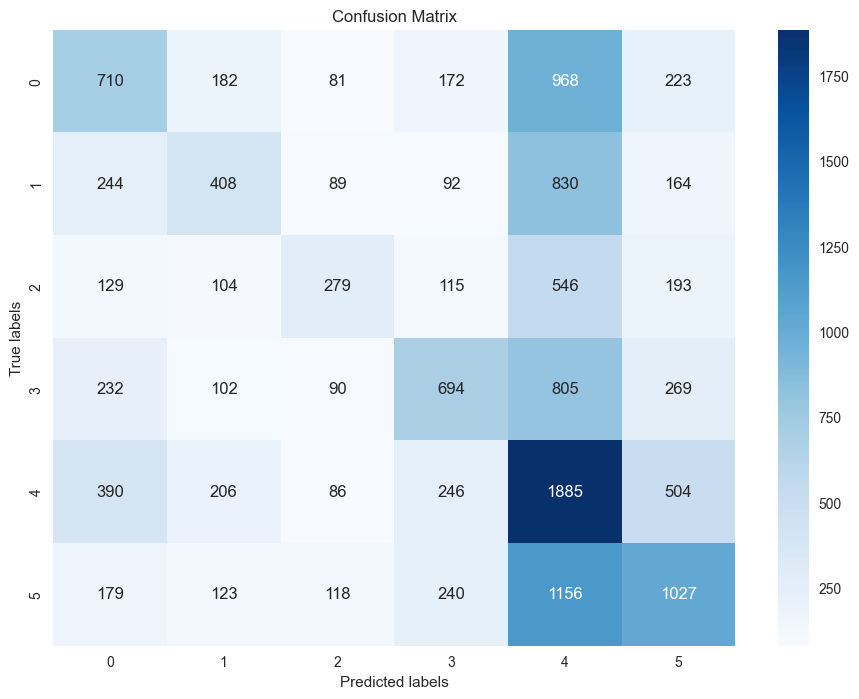

In [61]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, predicted)

# Plotting heatmap
plt.figure(figsize=(11, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Predicting sections with Naive Bayes

We can also try and observe how Naive Bayes would act on similarly, predicting the section of a word/sentence.

In [62]:
thesaurus_data.sample(5)

class              section  \
15200                 words relating to space           dimensions   
46546  words relating to the voluntary powers  individual volition   
17620                 words relating to space               motion   
45444  words relating to the voluntary powers  individual volition   
24680                words relating to matter       organic matter   

                      word  class_num  section_num  
15200             gridiron          1            9  
46546                 stow          4           17  
17620            extricate          1           11  
45444                dummy          4           17  
24680  fallacies of vision          2           14

Just as before, we create the pipeline.

In [63]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

X = thesaurus_data['word']
y_section = thesaurus_data['section_num']

and then run GridSearch:

In [64]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Single words, Bigrams, and Trigrams
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-1, 1e-2, 1e-3, 1e-4)
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(X, y_section)

In [65]:
print(gs_clf.best_estimator_)
print(gs_clf.best_params_)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB(alpha=0.1))])
{'clf__alpha': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}


Finally, we train based on what was suggested:

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_section, test_size=0.2, shuffle=True)

text_clf_b = Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 1))), 
                ('tfidf', TfidfTransformer(use_idf=True)), 
                ('clf', MultinomialNB(alpha=0.1))])

text_clf_b.fit(X_train, y_train)
predicted = text_clf_b.predict(X_test)

The results from predicting sections show that, again, the classifier performed poorly across almost all sections. 

Roget's Thesaurus contains sections with many synonym words, making it tough for a basic model as like Naive Bayes to tell them apart, especially if it only looks at individual words.

In [67]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.08      0.01      0.02       111
           1       0.28      0.08      0.13       208
           2       0.12      0.06      0.08       442
           3       0.06      0.02      0.03       335
           4       0.17      0.04      0.07       196
           5       0.41      0.22      0.28       364
           6       0.17      0.03      0.05       182
           7       0.14      0.05      0.07       403
           8       0.14      0.04      0.07       201
           9       0.13      0.07      0.09       578
          10       0.25      0.07      0.11       299
          11       0.25      0.16      0.19       771
          12       0.25      0.04      0.07        51
          13       0.09      0.02      0.04       315
          14       0.25      0.23      0.24       991
          15       0.30      0.29      0.29      1109
          16       0.26      0.20      0.22      1082
          17       0.18    

If we also plot the confusion matrix:

Again, notice, the high values that a certain section has, meaning, that our model frequently misclassified words, assigning them to the wrong sections. Something that we also interpreted when clustering to a class and section level, but also when classifying a class using Naive Bayes.

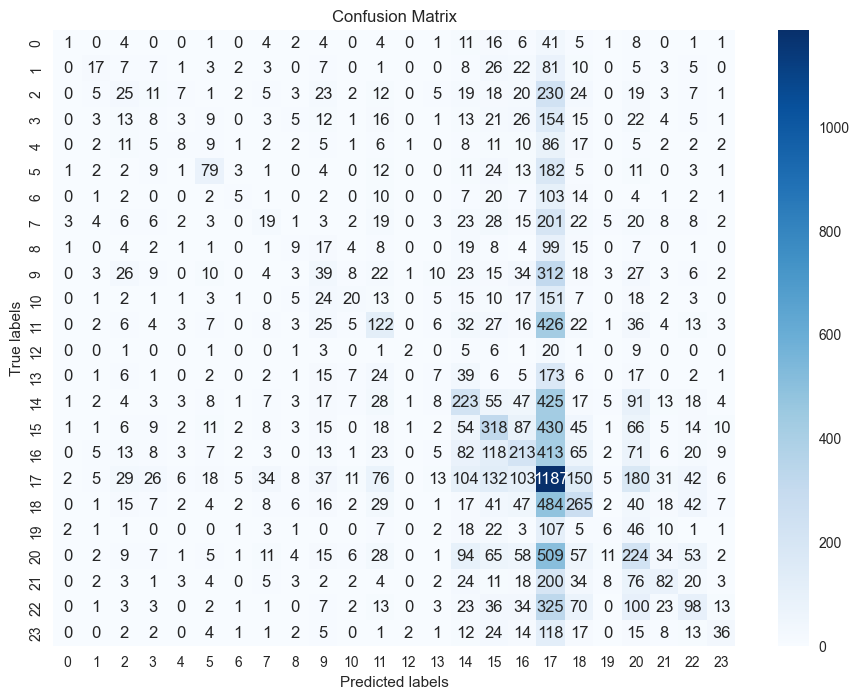

In [68]:
cm = metrics.confusion_matrix(y_test, predicted)

# Plotting heatmap
plt.figure(figsize=(11, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Assessing the issue

Remember that, our primary goal is to assess how well machine learning models can perform when working with a dataset like Roget's Thesaurus, where words are hierarchically ordered and grouped based on their meanings across specific classes and sections.

However, many words can have more than one meaning depending on the context.
For example, the word "bat" could be about an animal if we're talking about nature, or it could be about sports equipment if we're discussing baseball.

When we try to use model to figure out which group a word belongs to in the thesaurus, we run into this problem where, we provide the word itself to models, without any extra information about what the word means in like a specific instance.<br>
So, for instance the model doesn't understand if "bat" should go with animals or sports equipment. These were the issue we found using unsupervised techniques and models as simple as Naive Bayes.

#### Moving forward

Despite the challenges we've noticed, we will move forward with other supervised tecniques models by using the word embeddings we adhered. <br>

We know that embeddings provide a numerical representation of words, and advanced models can interpret these representations taking into account the broader context. 

However, we still don't expect to receive dramatic improvements when it comes to classification, just because we still face limitations when dealing with this lack of context in embeddings when context is crucial for understanding.

## Support Vector Machine

SVM is a ML Supervised model which is effective in high-dimensional spaces, making it particularly suitable for scenarios where you have a large number of features (or embeddings) making it a good choice for any sentiment analysis.

We go ahead and get our features and targets.

In [69]:
X = df_embedding_fasttext.drop(columns=['word', 'class_num', 'section_num']).values
y = df_embedding_fasttext['class_num'].values

print(X)
print(y)

[[ 0.03442806 -0.01596584  0.03304817 ... -0.04567408 -0.05000678
   0.01330804]
 [ 0.04448466 -0.04851294  0.04046202 ... -0.06028506 -0.10576231
   0.03635228]
 [ 0.01690578 -0.08090527  0.00173292 ... -0.07968753 -0.04587866
   0.02833311]
 ...
 [ 0.00639024 -0.00912531  0.00493055 ...  0.06455524  0.02735438
  -0.03050317]
 [-0.08935563 -0.0530014  -0.04098312 ...  0.10090097  0.08330183
   0.0108268 ]
 [ 0.00821559  0.00222637 -0.00193769 ... -0.07338869 -0.0229815
  -0.05250265]]
[0 0 0 ... 5 5 5]


We will also implement a function to, instead work with a random subset of our initial data, in order to ensure quicker experimentantions and a more manageable dataset.

Lastly, we encapsulate the splitting procedure into a function for convenience purposes.

In [70]:
def get_random_percentage_data(X, y, percentage=0.5):    
    total_samples = len(X)
    subset_size = int(total_samples * percentage)
    
    # Generating the random indices
    random_indices = np.random.choice(total_samples, subset_size, replace=False)
    
    X_subset = X[random_indices]
    
    y_subset = y[random_indices]
    
    return X_subset, y_subset

def split_data(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
    return X_train, y_train, X_test, y_test

X_subset, y_subset = get_random_percentage_data(X, y)
X_train, y_train, X_test, y_test = split_data(X_subset, y_subset)

We now proceed to experiment with the SVM model, encapsulating the training and evaluation process within a function. Like many machine learning models have a wide range of hyper-paremeters, SVM works with:

* `kernel` which helps decide what kind of line to draw. Here, we're using a straight line because our data seems to work well with that.
* `gamma` is about how much we allow our line to bend to get things right. A low value, that is, 0.001, means we're keeping our line pretty straight, avoiding overly complex solutions that might not work well with new, unseen data.
* `C` 'is a setting in our model that lets us adjust how strict we are about making sure every data point is classified correctly.<br>
A smaller 'C' value means we're more okay with some mistakes.

In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

def run_and_evaluate_svc(kernel='linear', gamma=0.001, C=0.1):
    
    svc = SVC(kernel=kernel, gamma=gamma, C=C)
    svc.fit(X_train, y_train)

    y_pred_test = svc.predict(X_test)
    
    # Evaluate and print the φ report for the test set
    print("\nTest Set Classification Report:\n", classification_report(y_test, y_pred_test))
    
    cm = confusion_matrix(y_test, y_pred_test)
        
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

We go ahead and train.

The SVM model's results reveal that it, again, struggled to classify the words into their correct classes accurately, with an overall accuracy of 44%. 

One could say that it performed best for class 4, demonstrating some ability to identify words belonging to this class, but this is misleading as we already discussed earlier, just because the confusion matrix reveals a significant number of labels from other classes were incorrectly identified as class 4.


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.33      0.39      1131
           1       0.47      0.38      0.42       940
           2       0.46      0.31      0.37       719
           3       0.49      0.33      0.39      1062
           4       0.39      0.66      0.49      1705
           5       0.50      0.46      0.48      1384

    accuracy                           0.44      6941
   macro avg       0.46      0.41      0.42      6941
weighted avg       0.46      0.44      0.43      6941



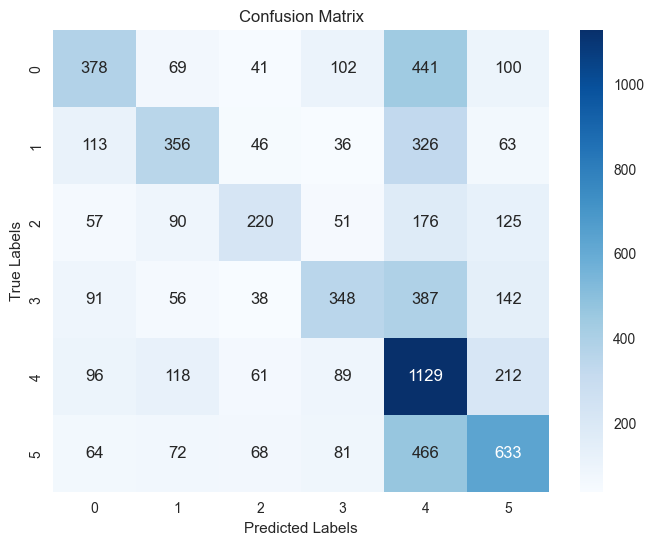

In [72]:
run_and_evaluate_svc()

## Neural Networks

Neural networks have demonstrated remarkable success across various machine learning applications, making it essential choice for us to explore on how these models could assist in classifying words or sentences from Roget's Thesaurus into their respective classes or sections.

We first go ahead and import the libraries we are going to use.

In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers

2024-02-24 18:10:25.424807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


and then, receive and split our data, just as before:

In [74]:
X = df_embedding_fasttext.drop(columns=['word', 'class_num', 'section_num']).values
y = df_embedding_fasttext['class_num'].values

X_train, y_train, X_test, y_test = split_data(X, y)

We will start with a simple, baseline model, and progressively explore more complex models and architectures to determine if they offer any improvement for our purposes.

Initially, we're employing a model composed of three layers: 
* The first being a dense layer with a single neuron activated by the ReLU function, designed to process our 300-dimensional input data. 
* Following this, we introduce another dense layer with 8 neurons, also using the ReLU activation function.
* The final layer consists of 10 neurons, aligning with the number of classes we aim to classify.<br> 
Notice that, we are skipping softmax activation, since we're handling the output as logits.

In [75]:
classes = 10

small_model = tf.keras.Sequential([
    keras.layers.Dense(1, activation='relu', input_shape=(300,)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(classes) # Softmax is skipped since we will be using "logits=True"
])

2024-02-24 18:11:14.241895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We will now encapsulate the model compilation and fitting process into a function. <br>
This will receive the training data, the model to be trained, an optional optimizer, the maximum number of epochs for training, an array of callbacks to be used. If no optimizer is specified, the function will create an Adam optimizer. 

Finally, the model loss function will be sparse categorical crossentropy as it is well-suited for multi-class classification problems where the classes are discrete.

In [76]:
def compile_and_fit(x_train, y_train, model, optimizer=None, 
                    max_epochs=100, callbacks=[], lr=0.001):
    
    if not optimizer:
        optimizer = get_optimizer(lr)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    history = model.fit(
        x_train,
        y_train,
        epochs=max_epochs,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=2)
    
    return history

def get_optimizer(lr):
    return tf.keras.optimizers.legacy.Adam(lr)

We go ahead and train.

We observe that as the number of epochs increases, step-wise improvements in both training and validation loss are noticed, suggesting the model is learning from the training data. 

However, the improvemens in accuracy are small, and the validation accuracy tops around 32%, which suggests the model's learning is limited, thus, our current architecture might not be complex enough to in order to capture the full relationships or patterns in and beteen the data.

In [77]:
small_history = compile_and_fit(X_train, y_train, small_model, max_epochs=25)

Epoch 1/25
1388/1388 - 4s - loss: 1.8229 - accuracy: 0.2368 - val_loss: 1.6847 - val_accuracy: 0.2678 - 4s/epoch - 3ms/step
Epoch 2/25
1388/1388 - 3s - loss: 1.6543 - accuracy: 0.2812 - val_loss: 1.6389 - val_accuracy: 0.2935 - 3s/epoch - 2ms/step
Epoch 3/25
1388/1388 - 2s - loss: 1.6274 - accuracy: 0.2991 - val_loss: 1.6266 - val_accuracy: 0.3002 - 2s/epoch - 2ms/step
Epoch 4/25
1388/1388 - 2s - loss: 1.6183 - accuracy: 0.3062 - val_loss: 1.6225 - val_accuracy: 0.3040 - 2s/epoch - 2ms/step
Epoch 5/25
1388/1388 - 2s - loss: 1.6137 - accuracy: 0.3109 - val_loss: 1.6207 - val_accuracy: 0.3025 - 2s/epoch - 2ms/step
Epoch 6/25
1388/1388 - 2s - loss: 1.6111 - accuracy: 0.3145 - val_loss: 1.6191 - val_accuracy: 0.3093 - 2s/epoch - 2ms/step
Epoch 7/25
1388/1388 - 2s - loss: 1.6088 - accuracy: 0.3143 - val_loss: 1.6181 - val_accuracy: 0.3119 - 2s/epoch - 2ms/step
Epoch 8/25
1388/1388 - 2s - loss: 1.6077 - accuracy: 0.3177 - val_loss: 1.6163 - val_accuracy: 0.3115 - 2s/epoch - 2ms/step
Epoch 9/

To help us further evaluate the results, we will also employ a function to visualize the training and validation loss across the epochs.

Both training and validation loss seem to decrease, indicating that the model is learning from the training data, and the losses are diverging.

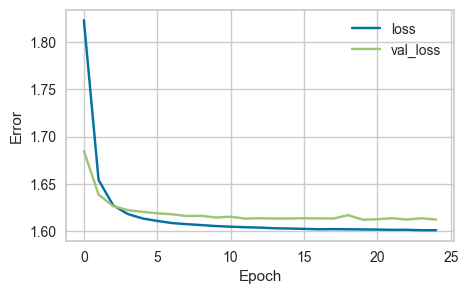

In [78]:
def plot_loss(history):
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
def test_and_evaluate_model(model):
    
    test_loss, test_acc = model.evaluate(X_test, y_test)

    logits = model.predict(X_test)
    prediction_labels = np.argmax(logits, axis=1)

    formatted_accuracy = "{:.2f}".format(test_acc)
    print(formatted_accuracy)
    print(metrics.classification_report(y_test, prediction_labels))
    
plot_loss(small_history)

Let's slighlty adjust the model included an increased number of neurons in each layer:
* The first dense layer will have 4 neurons (from 1 neuron) with ReLU activation.
* The second dense layer's will now have 12 (from 8 neurons) with ReLU activation.
* This model will now be trained for 30 epochs.

We train:

In [79]:
small_model_more_neurons = tf.keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(300,)),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(10) # softmax is skipped since we are using "logits=True"
])

small_model_more_neurons_hist = compile_and_fit(X_train, y_train, small_model_more_neurons, max_epochs=30)

Epoch 1/30
1388/1388 - 3s - loss: 1.7015 - accuracy: 0.3036 - val_loss: 1.5481 - val_accuracy: 0.3559 - 3s/epoch - 2ms/step
Epoch 2/30
1388/1388 - 2s - loss: 1.5069 - accuracy: 0.3932 - val_loss: 1.4748 - val_accuracy: 0.4148 - 2s/epoch - 2ms/step
Epoch 3/30
1388/1388 - 2s - loss: 1.4590 - accuracy: 0.4282 - val_loss: 1.4512 - val_accuracy: 0.4330 - 2s/epoch - 2ms/step
Epoch 4/30
1388/1388 - 3s - loss: 1.4423 - accuracy: 0.4370 - val_loss: 1.4425 - val_accuracy: 0.4348 - 3s/epoch - 2ms/step
Epoch 5/30
1388/1388 - 2s - loss: 1.4340 - accuracy: 0.4426 - val_loss: 1.4381 - val_accuracy: 0.4440 - 2s/epoch - 2ms/step
Epoch 6/30
1388/1388 - 3s - loss: 1.4261 - accuracy: 0.4484 - val_loss: 1.4329 - val_accuracy: 0.4453 - 3s/epoch - 2ms/step
Epoch 7/30
1388/1388 - 3s - loss: 1.4197 - accuracy: 0.4517 - val_loss: 1.4281 - val_accuracy: 0.4461 - 3s/epoch - 2ms/step
Epoch 8/30
1388/1388 - 3s - loss: 1.4127 - accuracy: 0.4548 - val_loss: 1.4246 - val_accuracy: 0.4491 - 3s/epoch - 2ms/step
Epoch 9/

This modified model show a slight improvement in both training and validation accuracy.<br> 
Similarly, the loss on both training and validation datasets showed a slow decrease, indicating a better fit of the model to the data.

Notice however that the validation loss, has a tend to increase after epoch 25 or so, potentially due to the start of overfitting.

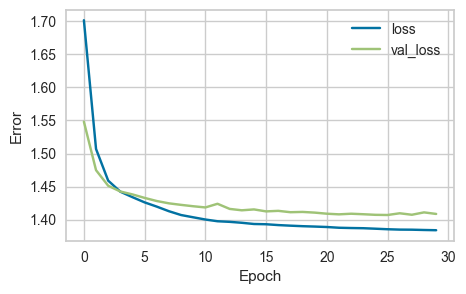

In [80]:
plot_loss(small_model_more_neurons_hist)

Our modified neural network model achieved an accuracy of 46% on the test set, primarily indicating that the adjustments made, that is, increasing the number of neuros in each layer helped the model to understand and capture more complex patterns.

In [81]:
test_and_evaluate_model(small_model_more_neurons)

434/434 [==============================] - 2s 4ms/step
0.45
              precision    recall  f1-score   support

           0       0.44      0.45      0.44      2334
           1       0.44      0.39      0.41      1863
           2       0.39      0.37      0.38      1340
           3       0.47      0.46      0.47      2077
           4       0.43      0.52      0.47      3346
           5       0.53      0.46      0.49      2921

    accuracy                           0.45     13881
   macro avg       0.45      0.44      0.44     13881
weighted avg       0.46      0.45      0.45     13881



Moving on, in order to further allow our model to train for longer epocs we will introduce the concept of `Early Stopping`, a regularization technique that stops the training phase when the model's performance on a validation set is not improving from epoch-to-epoch.

In [82]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20,  # Number of epochs to wait, 
                # until to start looking for improvements.
    verbose=1, 
    restore_best_weights=True  # Restoring the model weights from the epoch 
                               # with the best value of the monitored metric.
)

Then, in an attempty to enhance our model's capability to learn more complex patterns without hopefully, overfitting, we will expand its structure by adding more neurons and layers, and also incorporating in our new regulrization measuring.

In [83]:
small_model_more_neurons = tf.keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(300,)),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(classes) # softmax is skipped since we are using "logits=True"
])

small_model_more_neurons_hist = compile_and_fit(
    X_train, 
    y_train, 
    small_model_more_neurons, 
    max_epochs=100, 
    callbacks=[early_stopping]
)

Epoch 1/100
1388/1388 - 6s - loss: 1.6941 - accuracy: 0.2748 - val_loss: 1.5594 - val_accuracy: 0.3384 - 6s/epoch - 4ms/step
Epoch 2/100
1388/1388 - 4s - loss: 1.5251 - accuracy: 0.3789 - val_loss: 1.4705 - val_accuracy: 0.4252 - 4s/epoch - 3ms/step
Epoch 3/100
1388/1388 - 4s - loss: 1.4500 - accuracy: 0.4318 - val_loss: 1.4468 - val_accuracy: 0.4362 - 4s/epoch - 3ms/step
Epoch 4/100
1388/1388 - 4s - loss: 1.4345 - accuracy: 0.4402 - val_loss: 1.4364 - val_accuracy: 0.4419 - 4s/epoch - 3ms/step
Epoch 5/100
1388/1388 - 4s - loss: 1.4259 - accuracy: 0.4440 - val_loss: 1.4334 - val_accuracy: 0.4429 - 4s/epoch - 3ms/step
Epoch 6/100
1388/1388 - 4s - loss: 1.4162 - accuracy: 0.4493 - val_loss: 1.4305 - val_accuracy: 0.4352 - 4s/epoch - 3ms/step
Epoch 7/100
1388/1388 - 4s - loss: 1.4075 - accuracy: 0.4554 - val_loss: 1.4210 - val_accuracy: 0.4511 - 4s/epoch - 3ms/step
Epoch 8/100
1388/1388 - 4s - loss: 1.4007 - accuracy: 0.4587 - val_loss: 1.4165 - val_accuracy: 0.4493 - 4s/epoch - 3ms/step


There seems to be a slight improvement in the testing accuracy, however observe that the validation loss isconsistently hovered around a certain range without exhibiting any drastic changes. 

This behavior could mean that the model might have reached its learning capacity, and further adjustments or optimizations may be necessary for significant improvements.

In [84]:
test_loss, test_acc = small_model_more_neurons.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

434/434 [==============================] - 1s 2ms/step - loss: 1.4088 - accuracy: 0.4579
Test accuracy: 0.4578920900821686


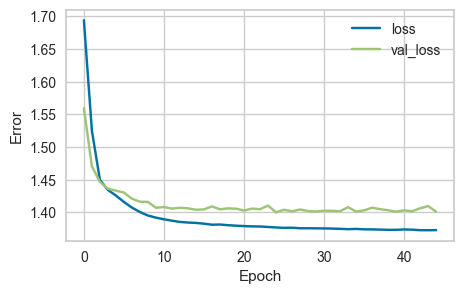

In [85]:
plot_loss(small_model_more_neurons_hist)

In the next model, we will try and assess the issue we encountered with the validation error being stale, for that:

* We will further enhance it by increasing both the number of hidden layers and the number of neurons within each layer.<br>
By doing this, we hope that our model can capture and recognise more complex patterns.<br> 
However, a more complex model also brings a higher risk of overfitting. 

* To counter that, we will introduce the dropout layers, basically a way of telling the model to achieve good performance even when some of the information (or some neurons) are missing or 'dropped out', thus hoping for a more 'generalized' solution.

We train again:

In [86]:
from tensorflow.keras import layers, models

simplified_model = tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(300,)), 
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dropout(0.25), 
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),
    
    keras.layers.Dense(classes)  # softmax is skipped since we are using "logits=True"
])

simplified_model_hist = compile_and_fit(
    X_train,
    y_train,
    simplified_model,
    max_epochs=100,
    callbacks=[early_stopping] 
)


Epoch 1/100
1388/1388 - 4s - loss: 1.5499 - accuracy: 0.3877 - val_loss: 1.4108 - val_accuracy: 0.4559 - 4s/epoch - 3ms/step
Epoch 2/100
1388/1388 - 3s - loss: 1.4277 - accuracy: 0.4515 - val_loss: 1.3822 - val_accuracy: 0.4708 - 3s/epoch - 2ms/step
Epoch 3/100
1388/1388 - 3s - loss: 1.3932 - accuracy: 0.4668 - val_loss: 1.3641 - val_accuracy: 0.4813 - 3s/epoch - 2ms/step
Epoch 4/100
1388/1388 - 3s - loss: 1.3729 - accuracy: 0.4739 - val_loss: 1.3659 - val_accuracy: 0.4789 - 3s/epoch - 2ms/step
Epoch 5/100
1388/1388 - 3s - loss: 1.3592 - accuracy: 0.4808 - val_loss: 1.3522 - val_accuracy: 0.4794 - 3s/epoch - 2ms/step
Epoch 6/100
1388/1388 - 3s - loss: 1.3431 - accuracy: 0.4873 - val_loss: 1.3594 - val_accuracy: 0.4775 - 3s/epoch - 2ms/step
Epoch 7/100
1388/1388 - 3s - loss: 1.3329 - accuracy: 0.4917 - val_loss: 1.3575 - val_accuracy: 0.4786 - 3s/epoch - 2ms/step
Epoch 8/100
1388/1388 - 3s - loss: 1.3206 - accuracy: 0.4941 - val_loss: 1.3481 - val_accuracy: 0.4846 - 3s/epoch - 2ms/step


The results show a notable improvement in both accuracy and loss metrics over the initial epochs.<br>
The model achieved a training accuracy of up to 53.33% and a slight improvement in validation accuracy that peaked around 49.01%. 

This suggests the model was effectively learning from the training data and generalizing reasonably well, well, in the very early epochs.

After reaching a peak performance, the model's validation accuracy does not significantly improve, starting slowly to show signs of not improvement at empoch as early as 9, and then start to gradually rise, a sign of overfitting.

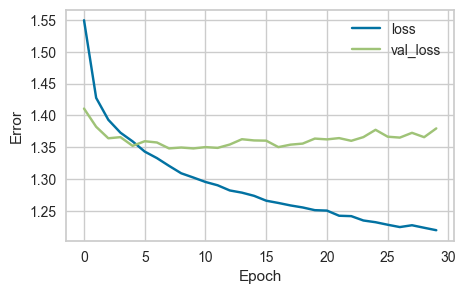

In [87]:
plot_loss(simplified_model_hist)

Finally, we observe that the model's overall test accuracy peaks at 49%, without any other noticable improvements.

In [88]:
test_and_evaluate_model(simplified_model)

434/434 [==============================] - 2s 3ms/step
0.47
              precision    recall  f1-score   support

           0       0.46      0.44      0.45      2334
           1       0.47      0.43      0.45      1863
           2       0.43      0.45      0.44      1340
           3       0.45      0.54      0.49      2077
           4       0.47      0.47      0.47      3346
           5       0.53      0.50      0.52      2921

    accuracy                           0.47     13881
   macro avg       0.47      0.47      0.47     13881
weighted avg       0.47      0.47      0.47     13881



Moving on and acknowledging the issues we faced in the earrlier model, we will introduce another regurilazation technique, the `L2 Reqularization`. <br>
This technique allows the model to keep its weights small, by adding a penalty on larger weights to the model's loss function, which the model tries to minimize during training. The idea is that smaller weights lead to simpler models, and simpler models are less likely to overfit to the training data.

Of course the choice of the value L2 regurilazation, like any other hyperparameter needs adjustments.<br>
For now, we will start with an init value of 0.001 that essentially controls how much we will penalize larger weights.

Finally, we also increase the value of the dropout value.

In [89]:
from tensorflow.keras import regularizers

l2_reg = 0.001

simplified_model_l2 = tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(300,),
                      kernel_regularizer=regularizers.l2(l2_reg)), 
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)), 
    keras.layers.Dropout(0.3), 
    
    keras.layers.Dense(64, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)),
    
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(classes)  # softmax is skipped since we are using "logits=True"
])

simplified_model_l2_hist = compile_and_fit(
    X_train,
    y_train,
    simplified_model_l2,
    max_epochs=100,
    callbacks=[early_stopping] 
)


Epoch 1/100
1388/1388 - 6s - loss: 1.6990 - accuracy: 0.3706 - val_loss: 1.5414 - val_accuracy: 0.4398 - 6s/epoch - 5ms/step
Epoch 2/100
1388/1388 - 4s - loss: 1.5563 - accuracy: 0.4325 - val_loss: 1.4943 - val_accuracy: 0.4576 - 4s/epoch - 3ms/step
Epoch 3/100
1388/1388 - 4s - loss: 1.5341 - accuracy: 0.4399 - val_loss: 1.4957 - val_accuracy: 0.4582 - 4s/epoch - 3ms/step
Epoch 4/100
1388/1388 - 3s - loss: 1.5242 - accuracy: 0.4442 - val_loss: 1.4992 - val_accuracy: 0.4557 - 3s/epoch - 2ms/step
Epoch 5/100
1388/1388 - 3s - loss: 1.5183 - accuracy: 0.4482 - val_loss: 1.4842 - val_accuracy: 0.4571 - 3s/epoch - 2ms/step
Epoch 6/100
1388/1388 - 3s - loss: 1.5138 - accuracy: 0.4494 - val_loss: 1.4828 - val_accuracy: 0.4623 - 3s/epoch - 2ms/step
Epoch 7/100
1388/1388 - 4s - loss: 1.5083 - accuracy: 0.4505 - val_loss: 1.4719 - val_accuracy: 0.4689 - 4s/epoch - 3ms/step
Epoch 8/100
1388/1388 - 3s - loss: 1.5036 - accuracy: 0.4544 - val_loss: 1.4808 - val_accuracy: 0.4614 - 3s/epoch - 2ms/step


Notice that in this case the loss went up, something of course expected, as by introducing L2 we are penalizing the network for having large values for weights, so the loss goes up, because it’s harder to fit (and overfit) the training data. <br>
This constraines the model to find simpler patterns that are more likely to generalize well to unseen data.

Inspect also that aa dropout rate of 30%, meaning less than half of the neuron's outputs are zeroed out at each training step, is quite aggressive.<br>
But, the fact that this strategy worked in some sense "better" for our model, suggests that could have been more likely to overfit with a lower dropout rate something that we indeed confirmed earlier. Thus, this higher rate combined with L2 reguralization seem to improved the model's ability to generalize to new data without overfitting.

In [90]:
test_and_evaluate_model(simplified_model_l2)

434/434 [==============================] - 1s 2ms/step
0.48
              precision    recall  f1-score   support

           0       0.46      0.44      0.45      2334
           1       0.43      0.53      0.48      1863
           2       0.45      0.38      0.41      1340
           3       0.50      0.45      0.48      2077
           4       0.45      0.53      0.49      3346
           5       0.57      0.47      0.51      2921

    accuracy                           0.48     13881
   macro avg       0.48      0.47      0.47     13881
weighted avg       0.48      0.48      0.48     13881



Notice also that, if we inspect the loss plot, we encounter this "zig-zagging" phenomenon of the validation loss.<br>
This phenomenon of validation loss going up and down during training however, is quite common for most ML algorithms, especially the ones that use some kind of stochastic process in training. If the data has a lot of noise and we're using a small learning rate, this zig-zagging can happen more often. <br>

This in some sense happens because the model might start to think the noise is part of what it needs to learn, which can make the error look different when we check how well the model is doing on new data compared to what it was trained on. <br>
But if we train the model for enough time and the error gets smaller on average, it could mean that the model is learning well despite these ups and downs.

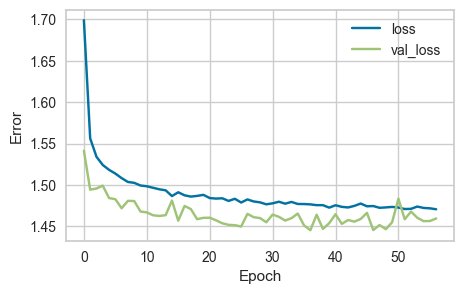

In [91]:
plot_loss(simplified_model_l2_hist)

Summing up, when comparing these two final models, each have its strengths and weaknesses. 

While the first model might perform well in terms of accuracy or performance, closely to the training data, it could struggle with new unseen data. 

On the other hand, the second model, with L2 regularization and a higher dropout rate, seems to "sacrifice" some accuracy on the training set for the ability to be more generalized when facing new unseen data.

### Classifying Sections - NN

Let's now go ahead and inspect how this 2 model's we found, could apply to predicting a section of a individual word/sentence.

Again, we receive and split the data:

In [92]:
X = df_embedding_fasttext.drop(columns=['word', 'class_num', 'section_num']).values
y = df_embedding_fasttext['section_num'].values

X_train, y_train, X_test, y_test = split_data(X, y)

Firstly, we will go ahead to train and evalute the model without L2 Reg.

In [93]:
sections = 24

simplified_model_sect = tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(300,)), 
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(128, activation='relu'), 
    keras.layers.Dropout(0.3), 
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(24)  # softmax is skipped since we are using "logits=True"
])

simplified_model_sect_hist = compile_and_fit(
    X_train,
    y_train,
    simplified_model_sect,
    max_epochs=100,
    callbacks=[early_stopping] 
)


Epoch 1/100
1388/1388 - 4s - loss: 2.6706 - accuracy: 0.2056 - val_loss: 2.4484 - val_accuracy: 0.2759 - 4s/epoch - 3ms/step
Epoch 2/100
1388/1388 - 3s - loss: 2.4591 - accuracy: 0.2683 - val_loss: 2.3471 - val_accuracy: 0.2946 - 3s/epoch - 2ms/step
Epoch 3/100
1388/1388 - 3s - loss: 2.3972 - accuracy: 0.2878 - val_loss: 2.3278 - val_accuracy: 0.3069 - 3s/epoch - 2ms/step
Epoch 4/100
1388/1388 - 3s - loss: 2.3650 - accuracy: 0.2974 - val_loss: 2.3045 - val_accuracy: 0.3133 - 3s/epoch - 2ms/step
Epoch 5/100
1388/1388 - 3s - loss: 2.3371 - accuracy: 0.3030 - val_loss: 2.2910 - val_accuracy: 0.3133 - 3s/epoch - 2ms/step
Epoch 6/100
1388/1388 - 3s - loss: 2.3211 - accuracy: 0.3075 - val_loss: 2.2871 - val_accuracy: 0.3146 - 3s/epoch - 2ms/step
Epoch 7/100
1388/1388 - 4s - loss: 2.3055 - accuracy: 0.3138 - val_loss: 2.2696 - val_accuracy: 0.3175 - 4s/epoch - 3ms/step
Epoch 8/100
1388/1388 - 3s - loss: 2.2907 - accuracy: 0.3175 - val_loss: 2.2663 - val_accuracy: 0.3204 - 3s/epoch - 2ms/step


The model started well, the training and validation accuracy show slight improvements over time, but the validation loss begins to increase after a certain point, indicating the model might be starting to overfit to the training data.

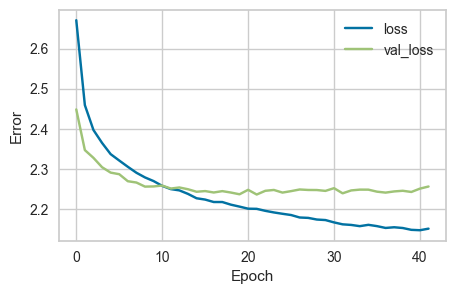

In [94]:
plot_loss(simplified_model_sect_hist)

then we trained with the L2 Reg:

In [95]:
l2_reg = 0.001

simplified_model_l2_sec = tf.keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(300,),
                      kernel_regularizer=regularizers.l2(l2_reg)), 
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)), 
    keras.layers.Dropout(0.3), 
    
    keras.layers.Dense(64, activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)),
    
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(sections)  # softmax is skipped since we are using "logits=True"
])

simplified_model_l2_sect_hist = compile_and_fit(
    X_train,
    y_train,
    simplified_model_l2_sec,
    max_epochs=100,
    callbacks=[early_stopping] 
)


Epoch 1/100
1388/1388 - 9s - loss: 2.8126 - accuracy: 0.1950 - val_loss: 2.6213 - val_accuracy: 0.2438 - 9s/epoch - 7ms/step
Epoch 2/100
1388/1388 - 4s - loss: 2.6373 - accuracy: 0.2404 - val_loss: 2.5603 - val_accuracy: 0.2569 - 4s/epoch - 3ms/step
Epoch 3/100
1388/1388 - 4s - loss: 2.5971 - accuracy: 0.2504 - val_loss: 2.5561 - val_accuracy: 0.2504 - 4s/epoch - 3ms/step
Epoch 4/100
1388/1388 - 8s - loss: 2.5763 - accuracy: 0.2534 - val_loss: 2.5250 - val_accuracy: 0.2625 - 8s/epoch - 6ms/step
Epoch 5/100
1388/1388 - 7s - loss: 2.5635 - accuracy: 0.2621 - val_loss: 2.5048 - val_accuracy: 0.2740 - 7s/epoch - 5ms/step
Epoch 6/100
1388/1388 - 5s - loss: 2.5604 - accuracy: 0.2636 - val_loss: 2.5049 - val_accuracy: 0.2781 - 5s/epoch - 4ms/step
Epoch 7/100
1388/1388 - 4s - loss: 2.5500 - accuracy: 0.2656 - val_loss: 2.5002 - val_accuracy: 0.2775 - 4s/epoch - 3ms/step
Epoch 8/100
1388/1388 - 4s - loss: 2.5460 - accuracy: 0.2688 - val_loss: 2.4949 - val_accuracy: 0.2800 - 4s/epoch - 3ms/step


1388/1388 - 4s - loss: 2.4650 - accuracy: 0.2987 - val_loss: 2.4272 - val_accuracy: 0.3048 - 4s/epoch - 3ms/step
Epoch 67/100
1388/1388 - 4s - loss: 2.4665 - accuracy: 0.2990 - val_loss: 2.4283 - val_accuracy: 0.3050 - 4s/epoch - 3ms/step
Epoch 68/100
1388/1388 - 4s - loss: 2.4654 - accuracy: 0.2995 - val_loss: 2.4462 - val_accuracy: 0.2979 - 4s/epoch - 3ms/step
Epoch 69/100
1388/1388 - 6s - loss: 2.4639 - accuracy: 0.2986 - val_loss: 2.4208 - val_accuracy: 0.3089 - 6s/epoch - 5ms/step
Epoch 70/100
1388/1388 - 9s - loss: 2.4611 - accuracy: 0.3006 - val_loss: 2.4419 - val_accuracy: 0.2984 - 9s/epoch - 6ms/step
Epoch 71/100
1388/1388 - 9s - loss: 2.4595 - accuracy: 0.3014 - val_loss: 2.4370 - val_accuracy: 0.3032 - 9s/epoch - 6ms/step
Epoch 72/100
1388/1388 - 4s - loss: 2.4643 - accuracy: 0.3017 - val_loss: 2.4239 - val_accuracy: 0.3127 - 4s/epoch - 3ms/step
Epoch 73/100
1388/1388 - 4s - loss: 2.4614 - accuracy: 0.3022 - val_loss: 2.4335 - val_accuracy: 0.3006 - 4s/epoch - 3ms/step
Epoch

Similarly, for the ridge modified model, it starts off with higher loss and lower accuracy b likely due to the constraints that are set by the regularization. The validation accuracy and loss shows that the model is somewhat stable, but the overall performance is slighlty lower compared to the non-regularized model, as expected. 

Again, each model, comes with each strengths and weaknesses so the decision between those two, depends on what wombeody values more.

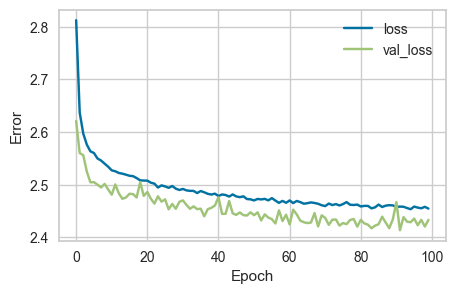

In [96]:
plot_loss(simplified_model_l2_sect_hist)

## Submission Instructions

* You must submit your assignment as a Jupyter notebook that will contain the full code and documentation of how you solved the questions, plus all accompanying material, such as embedding files, etc.

* You are not required to upload your assignment; you may, if you wish, do your work in GitHub and submit a link to the private repository you will be using. If you do that, make sure to share the private repository with your instructor. 

* You may also include plain Python files that contain code that is called by your Jupyter notebook.

* You must use [poetry](https://python-poetry.org/) for all dependency management. Somebody wishing to replicate your work should be able to do so by using the poetry file.